### Maxwell A. Fine 14880725
### Assingment 3: Stastical Methods in Astrophysics

# Do all plots have units ?
* ask about chi square units, and - values on errors

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.stats import pearsonr, spearmanr
from itertools import combinations # fancy nested for loop
from scipy.stats import norm
from scipy.stats import lognorm
import scipy.stats as sps
import scipy.integrate as spint
import scipy.integrate as spint
import scipy.interpolate as spinterp
from scipy.integrate import simps
from uncertainties import ufloat
from scipy.optimize import curve_fit
from lmfit import Model, Minimizer, Parameters, report_fit
import numpy as np
import lmfit 

# Set a seed for reproducibility
random_seed = 50

# Gaia correction term
gaia_corr = 0.029 # mas

assigned_clusters = [ 'NGC_6611', 'NGC_1817', 'NGC_663',]



# Task 1:
First, make stellar density profiles for each of your three clusters. To do this, you first need to create a
new column in your dataframe which contains the radial separation of each star (in arcseconds) from
the centre of its cluster, i.e. � = 3600. '(� − �̅)! + (� − �/)! where � and � are the RA and DE
positions of the star (in degrees) and �̅and �/ are the means of RA and DE for all the stars in the
cluster (i.e. the estimated location of the centre of the cluster). 

Then, use the radial locations of the
stars to make a histogram of stellar number density �∗ vs. radius, that is, the number of stars in a
radial bin, normalized by the area of the radial bin, which will correspond to an annulus on the sky
(use arcsec2 as the units of area). Choose appropriate radial binning and plot the stellar density
profiles (and error bars, if appropriate) for your 3 clusters on separate plots.

### Idea:

### Assumptions:

In [2]:
# Load in Data
# This time I am using _df to indicate it is a pandas df
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
#print(dr3stars[1].columns)
stars_df = pd.DataFrame(dr3stars[1].data)
stars_df['Name'] = stars_df['Name'].str.strip()
clcounts = stars_df.groupby(['Name']).size().reset_index(name='count') 


# Lets calculate Mean Ra, Dec for the clusters and add it as a Col in the df
stars_df['cluster_mean_RAdeg'] = stars_df.groupby('Name')['RAdeg'].transform('mean')
stars_df['cluster_mean_DEdeg'] = stars_df.groupby('Name')['DEdeg'].transform('mean')

# Lets compute radial dinstance (in deg) of each star from the estimated cluster center (the means) and add it as a Col 
# Double check this works as intended 
stars_df['radial_separation_arcsec'] = 3600 * np.sqrt((stars_df['RAdeg'] - stars_df['cluster_mean_RAdeg'])**2
                                    + (stars_df['DEdeg'] - stars_df['cluster_mean_DEdeg'])**2)  # 3600 is the conversion factor 


# Mean Proper motion
# Quadrature sum of RA and dec to calculate proper motion
stars_df['abs_proper_motion'] = np.sqrt((stars_df['pmRA'] )**2
                                    + (stars_df['pmDE'] )**2) 


# grab assigned star clusters
assigned_clusters_df = stars_df[stars_df['Name'].isin(assigned_clusters)]


Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


In [3]:
def histrebin(mininbin,counts,edges):
    '''Takes as input a minimum counts per bin and a histogram counts and bin edges, and combines 
       adjacent histogram bins as needed so that no bin has less than the required minimum.
       Inputs:
           mininbin - required minimum counts/bin.
           counts, edges - input histogram counts/bin and bin edges arrays.
       Outputs:
           counts2, edges2 - rebinned counts/bin and bin edges arrays'''
    edges2=np.zeros(1)  
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        
    return counts2, edges2

In [4]:
# I feel like we are going to be plotting this a bunch so lets make a function 
def stellar_density_profile_plot(stars_df, cluster_name, model_fitting = False, nbins=50, minibin=20):
    ''''
    Calculate the stellar density profile'''

    source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

    hist, bins = np.histogram(source_distance, bins=nbins)  # Adjust the number of bins as needed
                                                                                      # Using SQRT of n rule for the moment
    
    # rebin the data 
    hist, bins = histrebin(mininbin=minibin,counts=hist,edges=bins)

    # Compute bin centers, convert into stellar density 
    bin_centers = (bins[:-1] + bins[1:]) / 2
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2) 
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area
    # calculate bin widths 
    bin_width = np.diff(bins)

    # Plotting
    fig = plt.figure(figsize=(14, 6), dpi=300)
    # Step plot to look like a histogram
    plt.scatter((bin_centers), stellar_density, alpha=0.4, color='teal',label='Data',zorder=1)
    plt.step(bin_centers, stellar_density, where='mid', color='teal', linewidth=1, alpha=0.4, zorder=1)
    plt.errorbar(bin_centers, stellar_density, yerr=std_stellar_den, xerr=bin_width/2, fmt='none', ecolor='teal', capsize=3, alpha=0.4)
    plt.title(cluster_name + ' N = '+ str(len(source_distance)) + '\nStellar Density Profile', size=15)
    plt.xlabel('Distance From Center (arcsec)', size=15)
    plt.ylabel('Sources Per (arcsec$^{-2}$)', size=15)
    plt.xscale('log')
    plt.yscale('log')
    plt.tick_params(axis='both', which='both', labelsize=12)
    plt.legend()
    plt.show()  


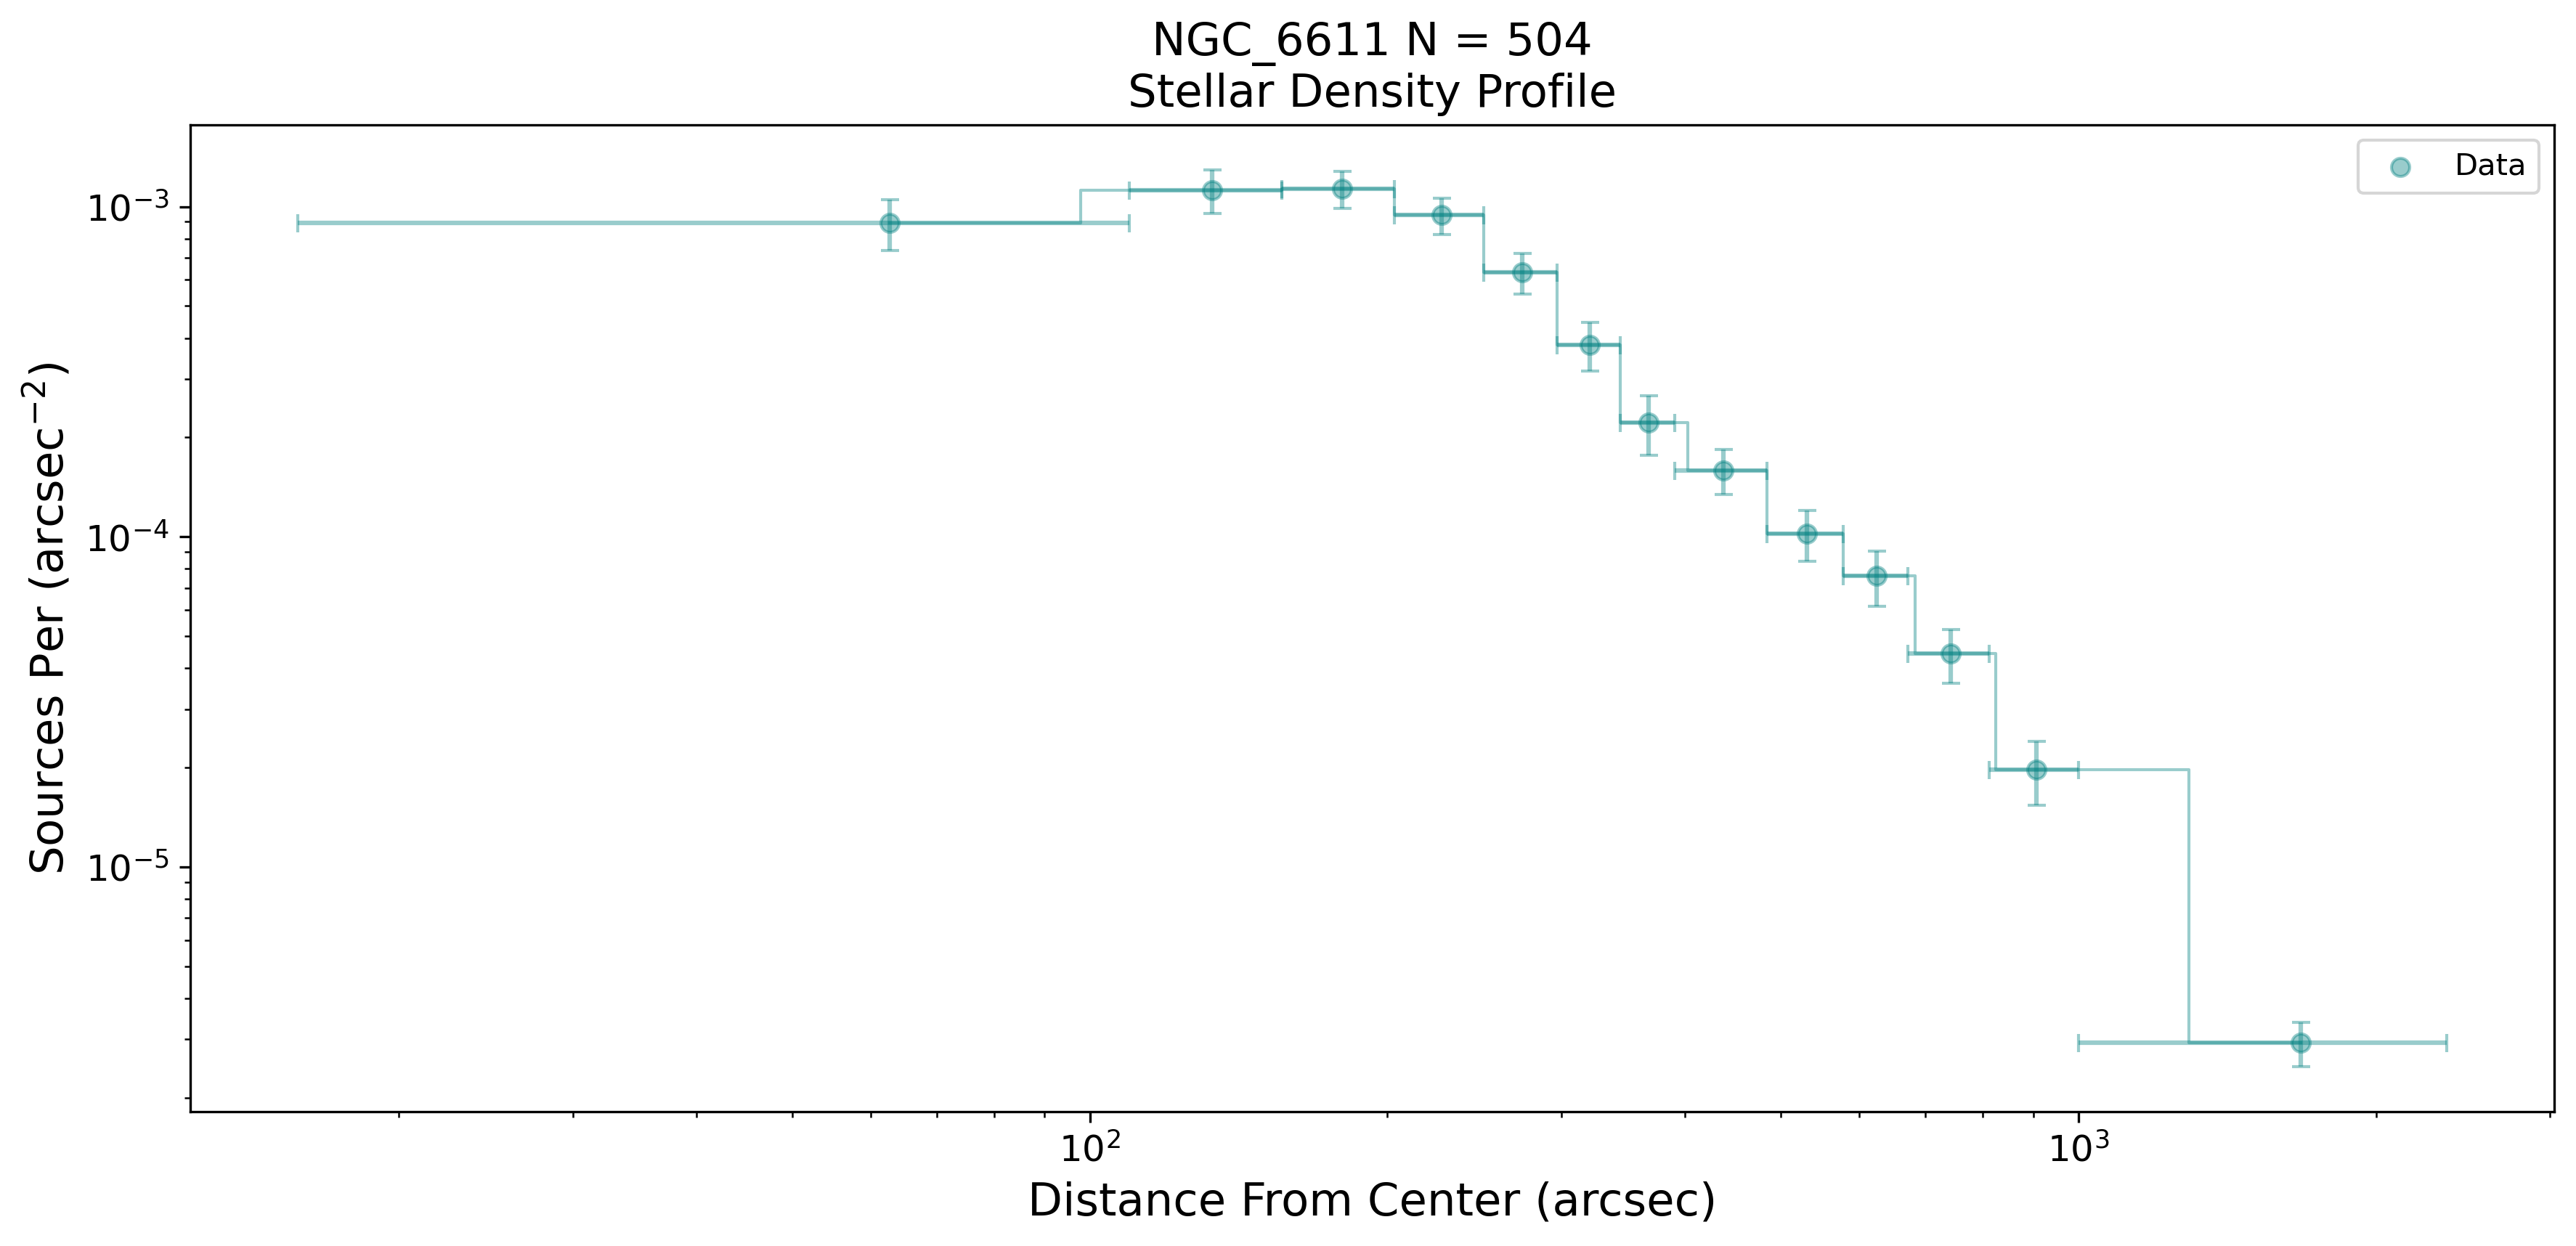

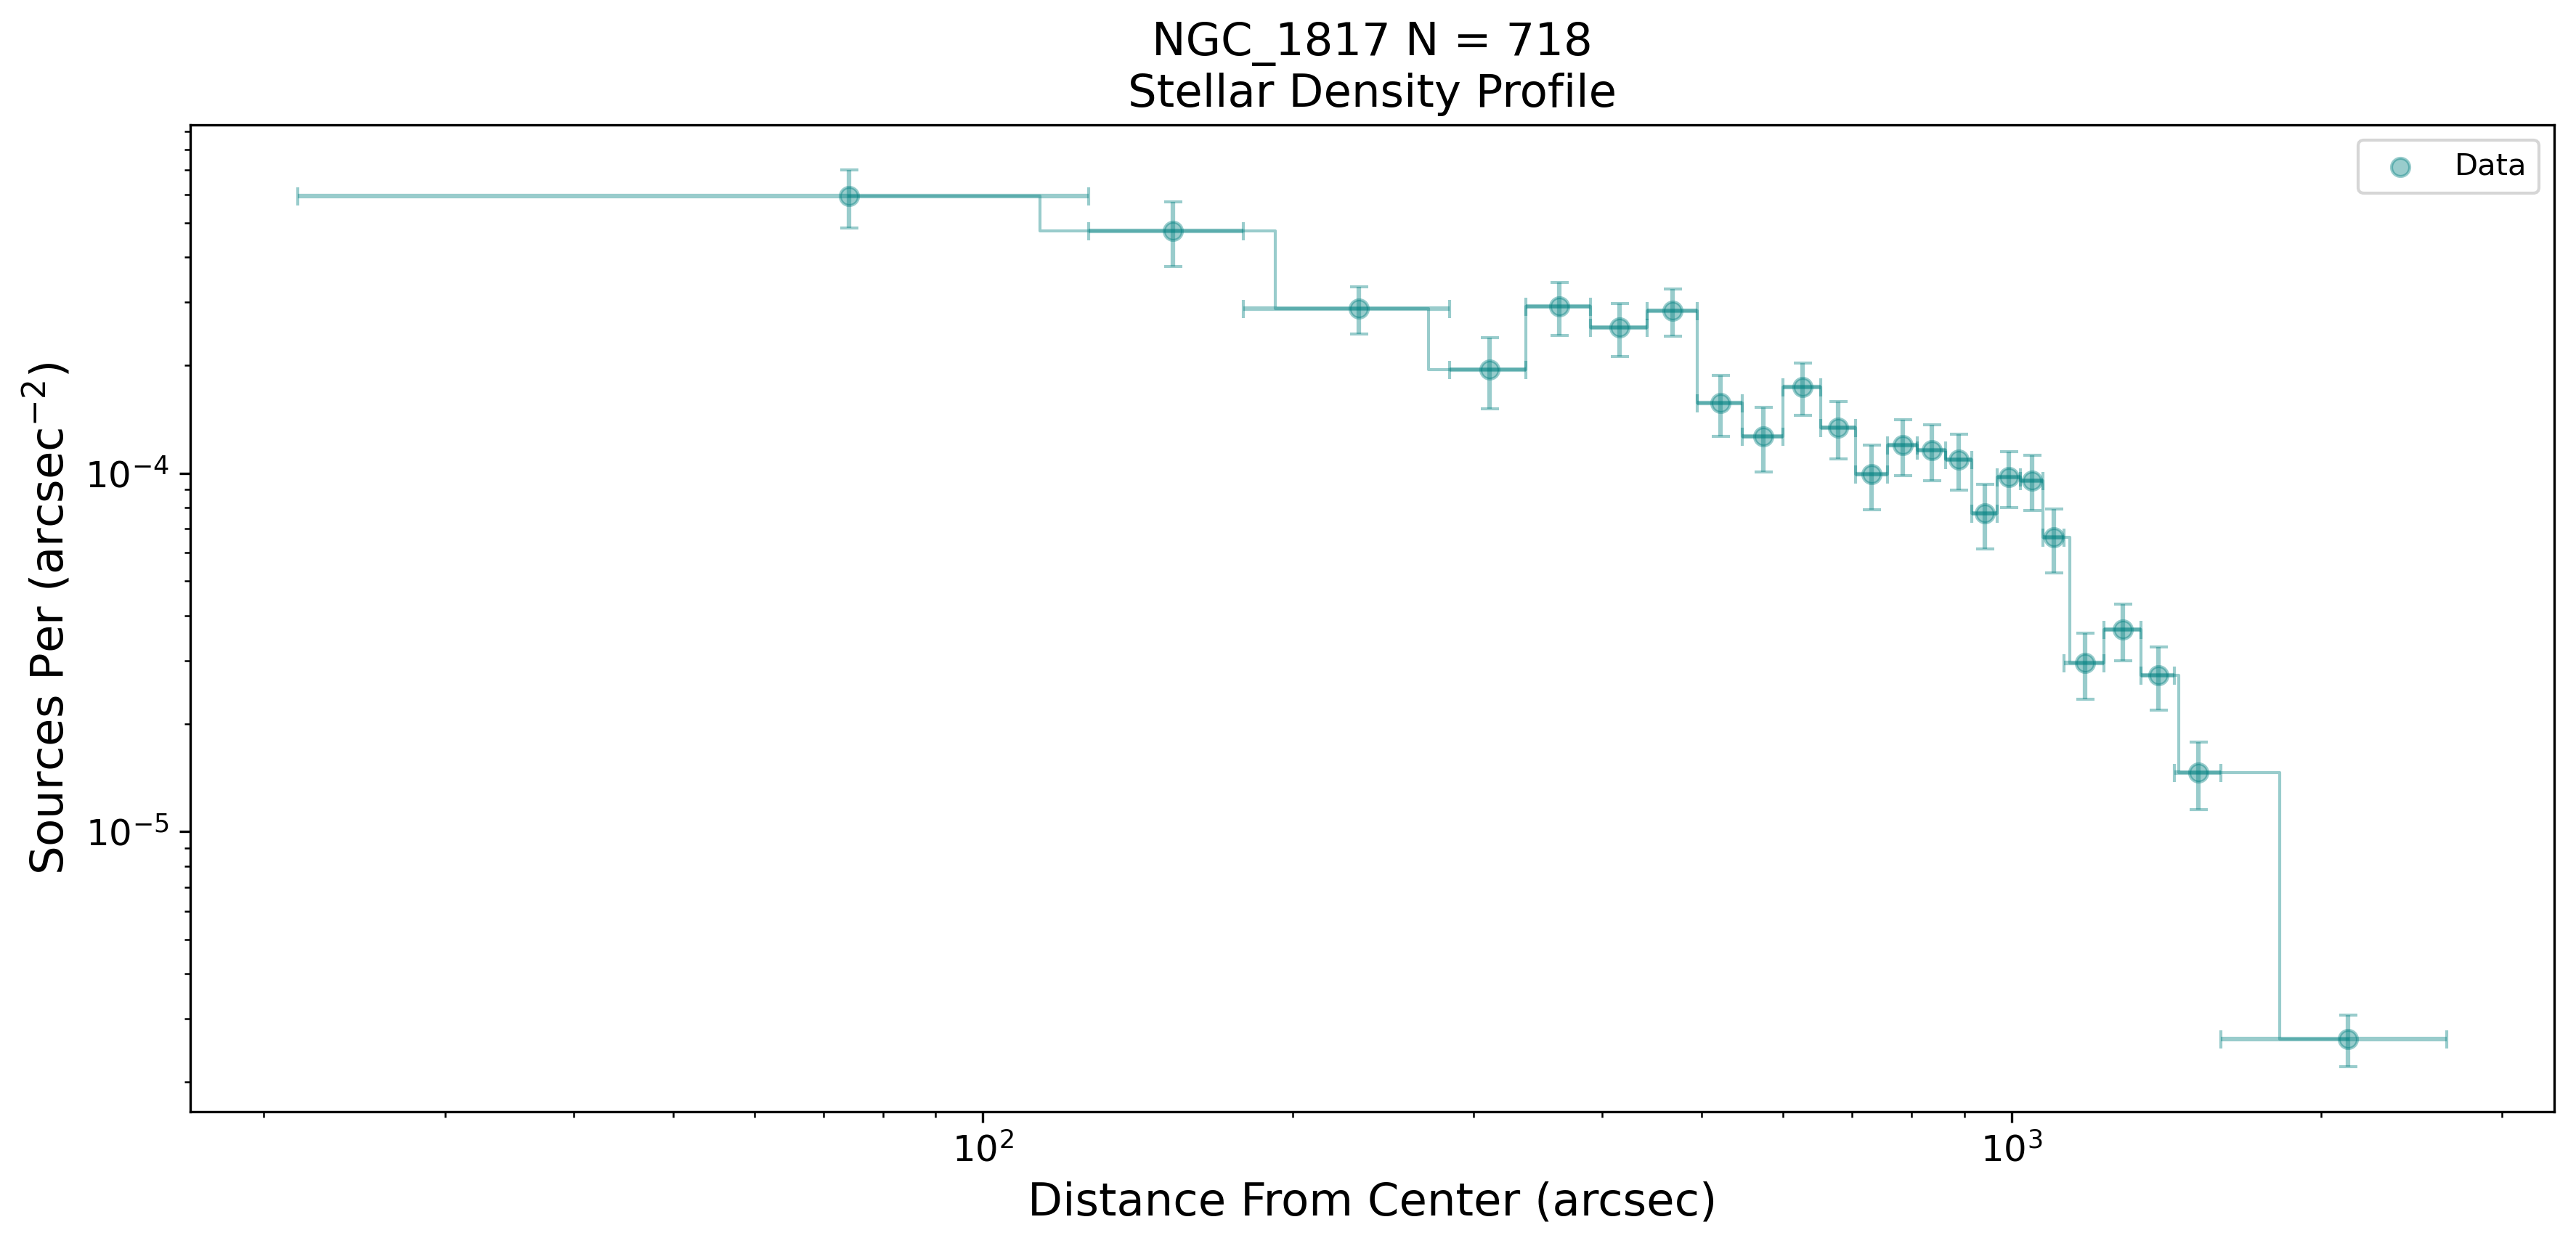

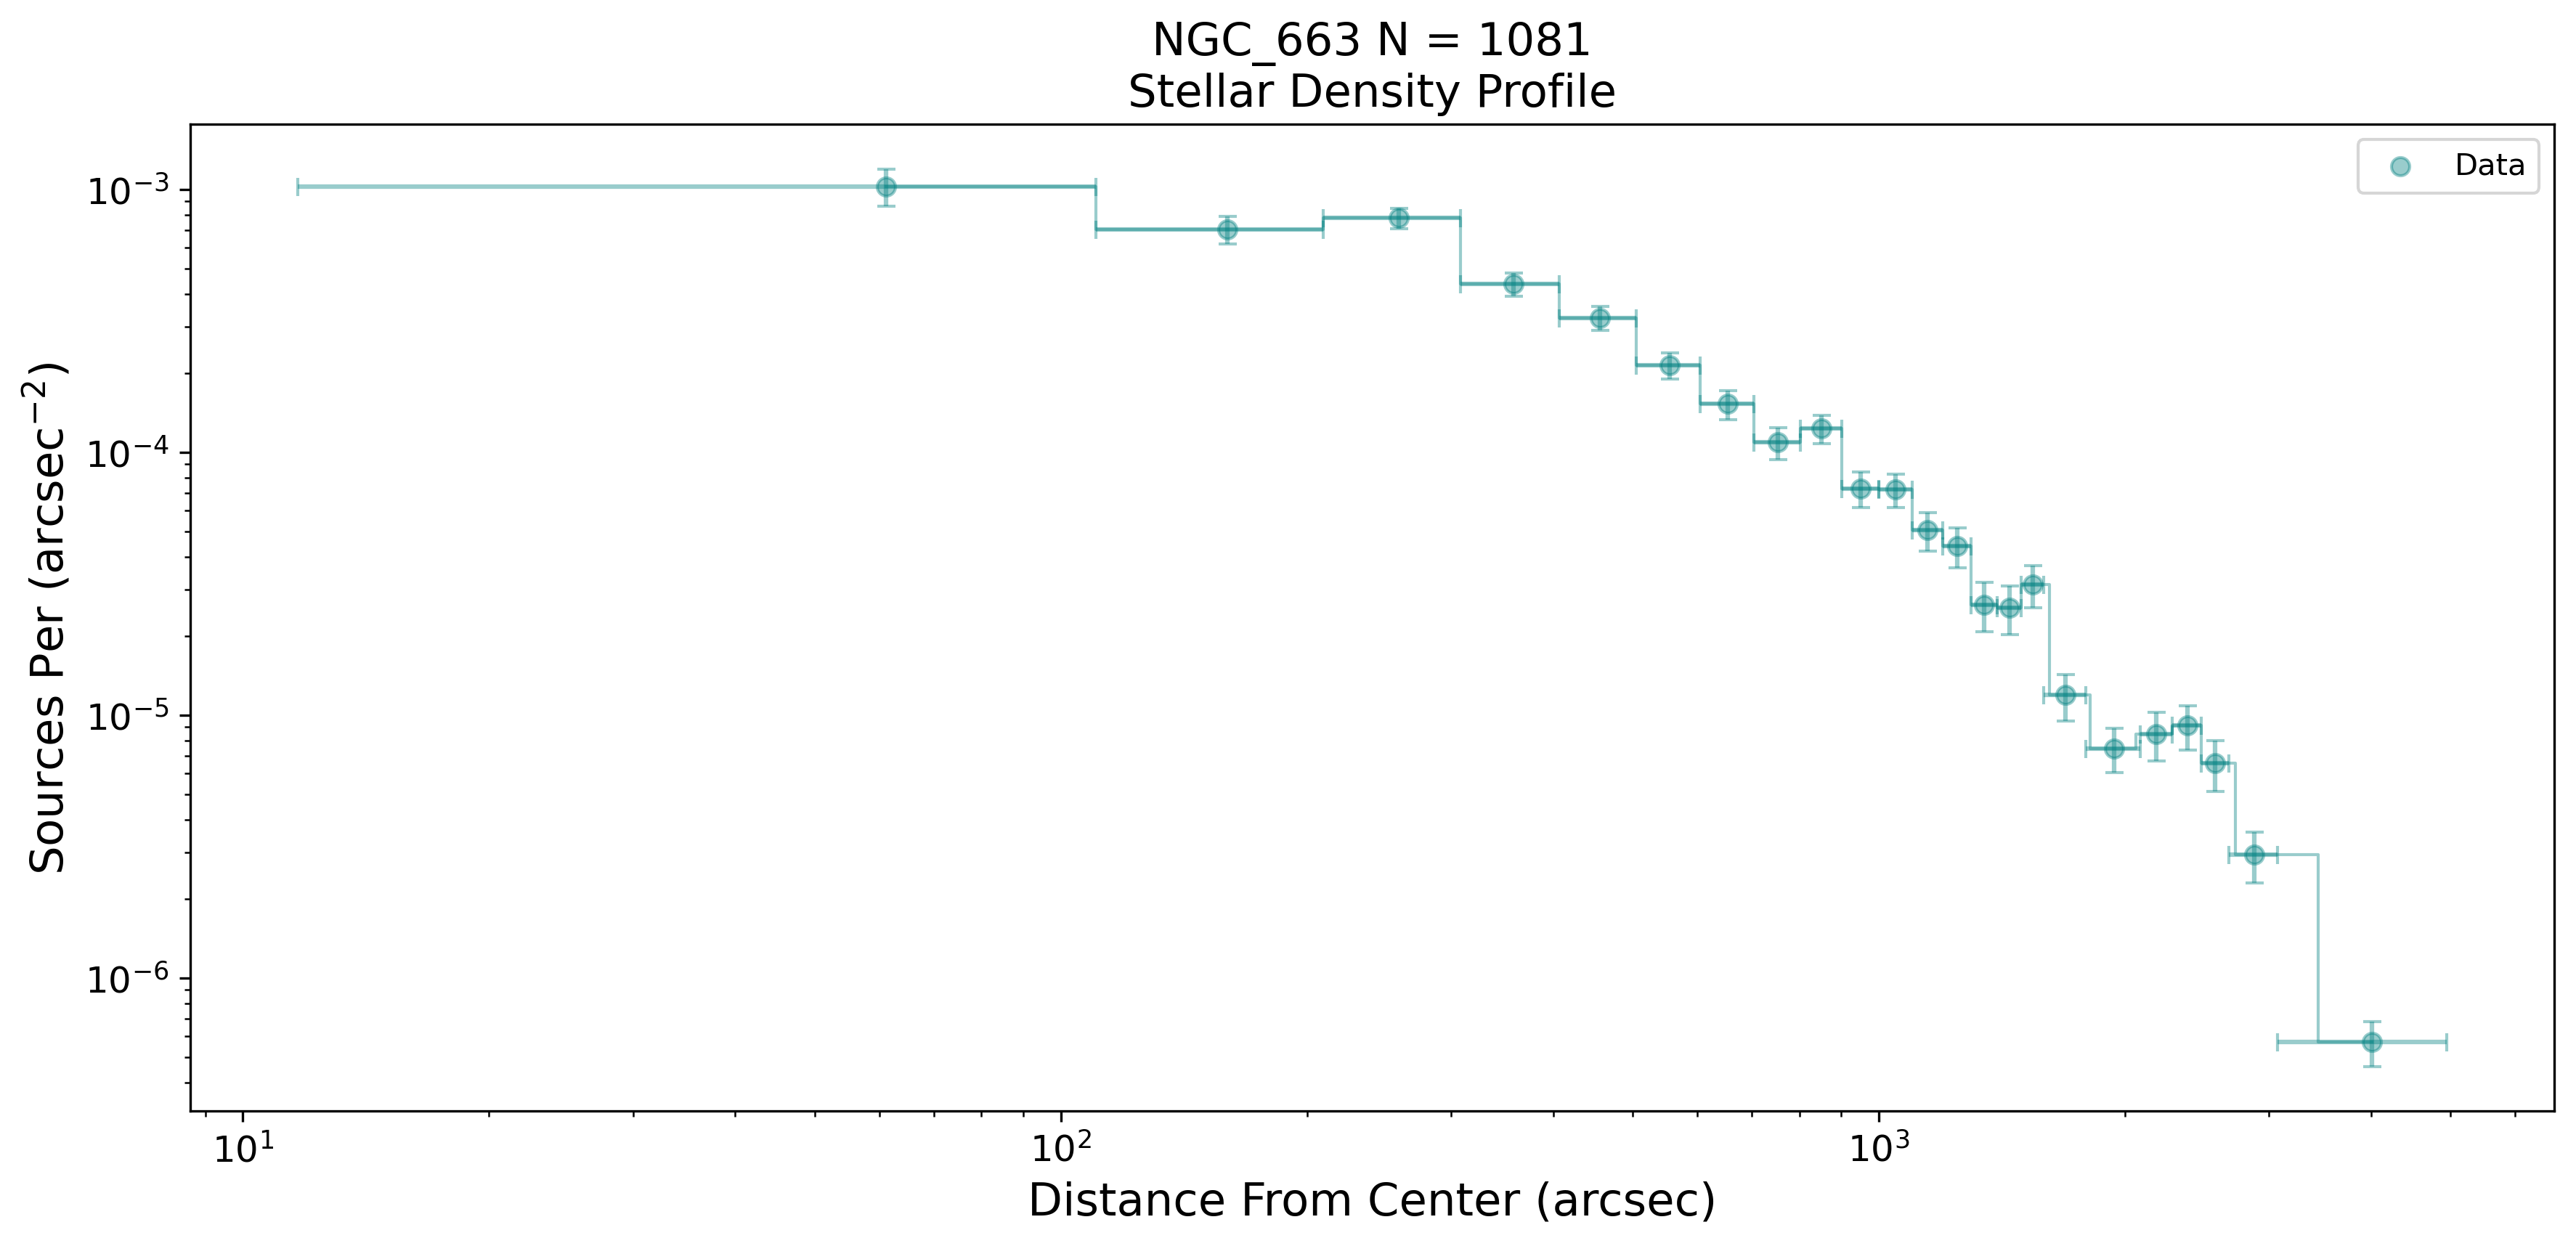

In [5]:
# loop through and plot
for cluster_name in assigned_clusters:
    stellar_density_profile_plot(stars_df, cluster_name)

### 1 Comment

# 2 Task:

Fit the King model to the stellar density profiles of your three clusters to obtain the MLEs for the
parameters and a goodness of fit of the model where appropriate. Plot your data again with the
model fits and residuals or ratios as appropriate.

Obtain 1-sigma confidence intervals on the model parameters, and if the intervals are not closed (i.e. they
include the bounds of the fitted parameters, or zero or infinity), obtain 3-� upper or lower (as
appropriate) limits on the parameters.

Kind Model

$$ \rho(r) = \rho_{0} [\frac{1}{\sqrt{1 + (r/r_{c})^2}} - \frac{1}{\sqrt{1 + (r_t/r_{c})^2}}]^2 + c $$

Where $r< r_c$

where for $r > r_t$, $\rho(r) = c$

Here, �' is a normalization factor, �0 is known as the core radius of the cluster, �/ is the tidal radius
(where the cluster is truncated), and � is a constant which corresponds to the number density of
unassociated foreground/background stars (which may be very small for these data, since the cluster
stars have already been pre-selected based on association in astrometric parameter space). 



* use  lmfit


### Idea:
* We modify our existing plotting function, maybe write a a function to do the fiting and confidence intervals 
* Define king model as its own function


### Assumptions:

In [6]:
#### copy and paste from lesson 

def model_bin(xbins, model, params):
    '''General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    bins =xbins # egdes 
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  
    for i, xval in enumerate(xbins[:-1]):
        ymod[i], ymoderr = spint.quad(lambda x: model(x, params),xbins[i],xbins[i+1])
        ymod[i] = ymod[i]/((xbins[i+1]-xbins[i])) 
       # ymod[i] = ymod[i] / annulus_area[i] # we now divide by the bin width to match the counts density
        # units of our data
    return ymod

def lmf_lsq_binresid(params,xdata,ydata,yerrs,model,output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values for
        binned data where the xdata are the input bin edges and ydata are the densities (integral over bin
        divided by bin width).
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
            if i == 0:
                resid = (ydata[i]-model_bin(xdata[i],model,params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model_bin(xdata[i],model,params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel



In [7]:
def king_model(x, params):
    r = x
    
    param_values = {}
    for param_name in params.keys():
        param_values[param_name] = params[param_name].value if isinstance(params[param_name], lmfit.Parameter) else params[param_name]

    # Now, you can access individual parameter values using param_values dictionary
    rho_knot = param_values['rho_knot']
    c = param_values['c']
    r_c = param_values['r_c']
    r_t = param_values['r_t']
        
    # Check if all parameters are numeric
    if not all(isinstance(param, (int, float)) for param in [rho_knot, c, r_c, r_t]):
        print('error in function')
        raise ValueError("All parameters must be numeric.")
    
    # Perform calculations
    frac1 = 1 / np.sqrt(1 + (r / r_c)**2)
    frac2 = 1 / np.sqrt(1 + (r_t / r_c)**2)
    rho_king = rho_knot * (frac1 - frac2)**2 + c
    
    # Use boolean indexing to set values for r > r_t if rho_king is a NumPy array
    if isinstance(rho_king, np.ndarray):
        rho_king[r > r_t] = c

    else:
        if r > r_t:
            rho_king = c
    
    return rho_king


In [8]:
def fit_and_plot_king(stars_df, cluster_name, print_output= True, plot=True):

    nbins = 50
    source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

    hist, bins = np.histogram(source_distance, bins=nbins, range=[0,np.max(source_distance)])  # Adjust the number of bins as needed
                                                                                        # Using SQRT of n rule for the moment
        
    # rebin the data 
    hist, bins = histrebin(mininbin=20,counts=hist,edges=bins)


    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
    #annulus_area = np.pi * np.diff(bins)**2
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area
    bin_width = np.diff(bins)
    # For convience 
    x_data = bins
    y_data = stellar_density
    y_data_errors = std_stellar_den
    x_data_errors = bin_width/2


    # all together now
    model = king_model
    output_resid = True

    # set params
    # set params
    param_guess = {'rho_knot': 1, 'c': 1e-5, 'r_c': 500, 'r_t': 1000}
    params = Parameters()
    params.add_many(('rho_knot', 1), ('c', 1e-5), ('r_c', 500), ('r_t', 1000))

    # Define parameter bounds
    param_bounds = {'rho_knot': (0, np.inf), 'c': (1e-12, 1e-4), 'r_c': (0, np.inf), 'r_t': (0, np.inf)}

    # Create Parameters with bounds
    params = lmfit.Parameters()
    for param_name, param_value in param_guess.items():
        bounds = param_bounds.get(param_name, (-np.inf, np.inf))
        params.add(param_name, value=param_value, min=bounds[0], max=bounds[1])



    xdata = [bins]
    ydata = [stellar_density]
    yerrs = [std_stellar_den]
    set_function = Minimizer(lmf_lsq_binresid, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')

    if print_output:
        report_fit(result)
        print("Minimum Chi-squared = "+str(result.chisqr)+" for "+str(result.nfree)+" d.o.f.")
        print("The goodness of fit is: ",sps.chi2.sf(result.chisqr,df=result.nfree))


    #### plot stuff

    if plot:
        # Extracting the best-fit parameters
        best_fit_params = result.params.valuesdict()

        # Generate x values for the model plot
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14,6), sharex=True, gridspec_kw={'height_ratios': [2, 1]}, dpi=300)

        x_data = bin_centers
        ax1.scatter(x_data, y_data, label='Data', color='teal',alpha=0.7)
        ax1.errorbar(bin_centers, stellar_density, yerr=std_stellar_den, xerr=x_data_errors, fmt='none', ecolor='teal', capsize=3, alpha=0.7)
        x_model = x_data
        ax1.step(x_data, king_model(x_data, best_fit_params), label='King Model', where='mid', linewidth=1.5, color='firebrick',alpha=0.7,)

        ax1.set_ylabel('Sources Per (arcsec$^{-2}$)', size=12)
        ax1.tick_params(axis='both', which='both', labelsize=12)
        ax1.legend(fontsize=12)
        ax1.set_yscale('log')
        ax1.set_xscale('log')

        # Plot residuals in the second subplot
        residuals = y_data - king_model(x_data, best_fit_params)
        # Data ratio 
        #ax2.scatter(x_data, result.best_fit/ y_data, label='Residuals', color='k', alpha=0.5)
        ax2.errorbar(x_data, y_data / king_model(x_data, best_fit_params), fmt='none', yerr = y_data_errors/y_data, 
                     label='Residuals', color='k', alpha=0.5, capsize=3,)
        ax2.scatter(x_data, y_data / king_model(x_data, best_fit_params), color='k', alpha=0.5, )
        ax2.axhline(1, color='black', linestyle='--', linewidth=1)
        ax2.set_xlabel('Distance From Center (arcsec)', size=12)
        ax2.set_ylabel('Data / Model', size=12)
        ax2.tick_params(axis='both', which='both', labelsize=12)

        # Plot garb
        plt.suptitle(cluster_name + ' N = '+ str(len(source_distance)) + '\nStellar Density Profile', size=12)
        plt.savefig(cluster_name +'_model_fit', bbox_inches='tight')
        plt.show()
    
    # now switch back for the vars we used for model fitting 
    xdata = x_data
    ydata = y_data
    yerrs = y_data_errors #std_stellar_den
    return result, xdata,ydata,yerrs

In [9]:
def lmf_lsq_resid(params,xdata,ydata,yerrs,model,output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values.
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1, n2 respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
            if i == 0:
                resid = (ydata[i]-model(xdata[i],params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model(xdata[i],params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model(xdata[i],params))
        return ymodel

def calc_error_chisq(delchisq,a_best,minchisq,a_grid,chisq_grid):
    '''Function to return upper and lower values of a parameter 'a' for a given delta-chi-squared
       Input:
           delchisq - the delta-chi-squared for the confidence interval required (e.g. 1 for 1-sigma error)
           a_best, minchisq - best-fitting value for 'a' and corresponding chi-squared minimum
           a_grid, chisq_grid - grid of 'a' and corresponding chi-squared values used for interpolation'''
    # First interpolate over the grid for values > a_best and find upper interval bound
    chisq_interp_upper = spinterp.interp1d(chisq_grid[a_grid > a_best],a_grid[a_grid > a_best])
    a_upper = chisq_interp_upper(minchisq+delchisq)
    # Interpolate for values <= a_best to find lower interval bound
    chisq_interp_lower = spinterp.interp1d(chisq_grid[a_grid <= a_best],a_grid[a_grid <= a_best])
    a_lower = chisq_interp_lower(minchisq+delchisq)  
    return [a_lower,a_upper]


def grid1d_chisqmin(a_name,a_range,a_steps,parm,model,xdata,ydata,yerrs):
    '''Uses lmfit. Finds best the fit and then carries out chisq minimisation for a 1D grid of fixed 
       parameters.
       Input: 
            a_name - string, name of 'a' parameter (in input Parameters object parm) to use for grid.
            a_range, a_steps - range (tuple or list) and number of steps for grid.
            parm - lmfit Parameters object for model to be fitted.
            model - name of model function to be fitted.
            xdata, ydata, yerrs - lists of data x, y and y-error arrays (as for the lmf_lsq_resid function)
        Output: 
            a_best - best-fitting value for 'a'
            minchisq - minimum chi-squared (for a_best)
            a_grid - grid of 'a' values used to obtain fits
            chisq_grid - grid of chi-squared values corresponding to a_grid'''
    a_grid = np.linspace(a_range[0],a_range[1],a_steps)
    chisq_grid = np.zeros(len(a_grid))
    # First obtain best-fitting value for 'a' and corresponding chi-squared
    set_function = Minimizer(lmf_lsq_resid, parm, fcn_args=(xdata, ydata, yerrs, model, True),
                             nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')
    minchisq = result.chisqr
    a_best = result.params.valuesdict()[a_name]
    # Now fit for each 'a' in the grid, to do so we use the .add() method for the Parameters object
    # to replace the value of a_name with the value for the grid, setting vary=False to freeze it
    # so it cannot vary in the fit (only the other parameters will be left to vary)
    for i, a_val in enumerate(a_grid):
        parm.add(a_name,value=a_val,vary=False)
        set_function = Minimizer(lmf_lsq_resid, parm, fcn_args=(xdata, ydata, yerrs, model, True), 
                                                                nan_policy='omit')
        result = set_function.minimize(method = 'leastsq')
        chisq_grid[i] = result.chisqr
    return a_best, minchisq, a_grid, chisq_grid 



def calc_error_chisq(delchisq, a_best, minchisq, a_grid, chisq_grid):
    # Upper bound
    upper_mask = a_grid > a_best
    if np.any(upper_mask) and (minchisq + delchisq <= max(chisq_grid[upper_mask])):
        chisq_interp_upper = spinterp.interp1d(chisq_grid[upper_mask], a_grid[upper_mask])
        a_upper = chisq_interp_upper(minchisq + delchisq)
    else:
        a_upper = None  # Interval extends beyond grid range

    # Lower bound
    lower_mask = a_grid <= a_best
    if np.any(lower_mask) and (minchisq + delchisq <= max(chisq_grid[lower_mask])):
        chisq_interp_lower = spinterp.interp1d(chisq_grid[lower_mask], a_grid[lower_mask])
        a_lower = chisq_interp_lower(minchisq + delchisq)
    else:
        a_lower = None  # Interval extends beyond grid range

    return [a_lower, a_upper]


The problem probably arises because the chisqr corresponding to your 1 or 3 sigma interval is higher than the chisqr array in your interval. You could avoid the error by manually checking if your minchisqr + delchisqr is lower than the maximum chisqr in your array, and if not, set the confidence interval to None on that side

In [12]:
# lets make a confidence interval function 

def get_confidence_intervals(result, stars_df, cluster_name, plotting=True, print_output=True):
        ### Confidence intervals 
    # aprox ~2 min run per cluster

    result = result # need to change for each cluster

    model = king_model
    par_names = ['gam0','E0','N'] # Names of parameters in Parameters object

    param_guess = {'rho_knot': 1, 'c': 1e-5, 'r_c': 500, 'r_t': 1000}
    par_names = list(param_guess.keys())
    n_steps = 100  # Number of steps in our grids
    # Ranges for each parameter - should aim for a few times times 1-sigma error estimated from covariance
    # We can specify by hand or use the values from the original minimize result if available:
    par_ranges = []
    for i, par_name in enumerate(par_names):
        # range min/max are best-fitting value -/+ four times the estimated 1-sigma error from variances 
        # (diagonals of covariance matrix)

        
        par_min = result.params.valuesdict()[par_name] - 5*np.sqrt(result.covar[i,i])
        par_max = result.params.valuesdict()[par_name] + 5*np.sqrt(result.covar[i,i])

        # need to set if statement for bounds
        # we do not want any negative bounds on physicial grounds
        if par_min < 0:
            par_min =0

        par_ranges.append([par_min,par_max])
    #par_ranges = [[109,112],[175,177],[204,206]]   # if specified by hand
    if print_output:
        print("Parameter ranges for grid:",par_ranges)

    # For convenience when plotting we will store our results in arrays, which we now set up:
    a_best = np.zeros(len(par_ranges))
    minchisq = np.zeros(len(par_ranges))
    a_grid = np.zeros((len(par_ranges),n_steps))
    chisq_grid = np.zeros((len(par_ranges),n_steps))
    a_int = np.zeros((len(par_ranges),2))

    # 3 sigma
    a_best3 = np.zeros(len(par_ranges))
    minchisq3 = np.zeros(len(par_ranges))
    a_grid3 = np.zeros((len(par_ranges),n_steps))
    chisq_grid3 = np.zeros((len(par_ranges),n_steps))
    a_int3 = np.zeros((len(par_ranges),2))

    delchisq = 1.0  # For 1-sigma errors for a single parameter 
    delchisq_3sigma = 9 # for 3-sigma errors for a single parameter
                        # I hope

    # 1 sigma
    # Now do the grid calculation for each parameter:
    if print_output:
        print('\n\nMLE with 1 Sigma Erros')
    for i, par_range in enumerate(par_ranges):
        params = Parameters()
        for param_name, param_value in param_guess.items():
            value = result.params.valuesdict()[par_name]
            params.add(param_name, value=value)
        a_best[i], minchisq[i], a_grid[i,:], chisq_grid[i,:] = grid1d_chisqmin(par_names[i],par_range,n_steps,params,model,
                                xdata,ydata,yerrs)
        
        a_int[i,:] = calc_error_chisq(delchisq,a_best[i],minchisq[i],a_grid[i,:],chisq_grid[i,:])
        if print_output:
            print('MLE '+par_names[i]+':',str(a_best[i]),
                'with 1 Sigma errors:',str((a_int[i,:]-a_best[i])))   
            

    # 3 sigma
    # Now do the grid calculation for each parameter:
    if print_output:
        print('\n\nMLE with 3 Sigma Erros')

    for i, par_range in enumerate(par_ranges):
        params = Parameters()
        for param_name, param_value in param_guess.items():
            value = result.params.valuesdict()[par_name]
            params.add(param_name, value=value)
        a_best3[i], minchisq3[i], a_grid3[i,:], chisq_grid3[i,:] = grid1d_chisqmin(par_names[i],par_range,n_steps,params,model,
                                xdata,ydata,yerrs)
        
        a_int3[i,:] = calc_error_chisq(delchisq_3sigma,a_best3[i],minchisq3[i],a_grid3[i,:],chisq_grid3[i,:])
        print('MLE '+par_names[i]+':',str(a_best3[i]),
            'with 3 Sigma errors:',str((a_int3[i,:]-a_best3[i])))

    if plotting:
        # Now plot along with a cross to mark the MLE and dotted lines to show the 1-sigma intervals
        par_xlabels = [r'$\Gamma_{0}$ (MeV)',r'$E_{0}$ (MeV)',r'$N$ (mb)']
        par_xlabels = par_names
        fig, (ax1, ax2, ax3, ax4,) = plt.subplots(1,4, figsize=(12,4), sharey=True, dpi=300)
        fig.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=0.1, hspace=None)
        for i, ax in enumerate([ax1, ax2, ax3, ax4]):
            ax.plot(a_grid[i,:],chisq_grid[i,:],color='#1E88E5')
            ax.scatter(a_best[i],minchisq[i],marker='+',color='#1E88E5')
            ax.vlines(a_int[i,:],ymin=0,ymax=100,color='#004D40',linestyle='dotted', label='1-Sigma')
            ax.vlines(a_int3[i,:],ymin=0,ymax=100,color='#9CF101',linestyle='-.', label='3-Sigma')
            
            ax.set_xlabel(par_xlabels[i],fontsize=12)
            ax.tick_params(axis='both', which='both', labelsize=12)
        ax1.set_ylabel(r'$\chi^{2}$',fontsize=12)
        ax1.set_ylim(np.min(chisq_grid[i,:]),70)


        source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

        plt.suptitle(cluster_name + ' N = '+ str(len(source_distance)) + '\nStellar Density Profile', size=12)
        plt.legend(fontsize=12)
        plt.savefig(cluster_name +'_confidence_interval', bbox_inches='tight')
        plt.show()

    # make a return line here
    # we want to return the 1, and 3 sigma values for the parameters 
    

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 15
    # variables        = 4
    chi-square         = 28.5106129
    reduced chi-square = 2.59187390
    Akaike info crit   = 17.6333930
    Bayesian info crit = 20.4655938
[[Variables]]
    rho_knot:  0.00193744 +/- 2.8063e-04 (14.48%) (init = 1)
    c:         1.9914e-06 +/- 1.0797e-06 (54.22%) (init = 1e-05)
    r_c:       226.909377 +/- 41.1763552 (18.15%) (init = 500)
    r_t:       1512.38280 +/- 293.063555 (19.38%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, r_t)        = -0.7628
    C(r_c, r_t)      = -0.7401
    C(c, r_c)        = +0.4985
    C(rho_knot, r_c) = -0.3207
    C(rho_knot, r_t) = -0.2851
    C(rho_knot, c)   = +0.2491
Minimum Chi-squared = 28.510612852844798 for 11 d.o.f.
The goodness of fit is:  0.002702189642467415


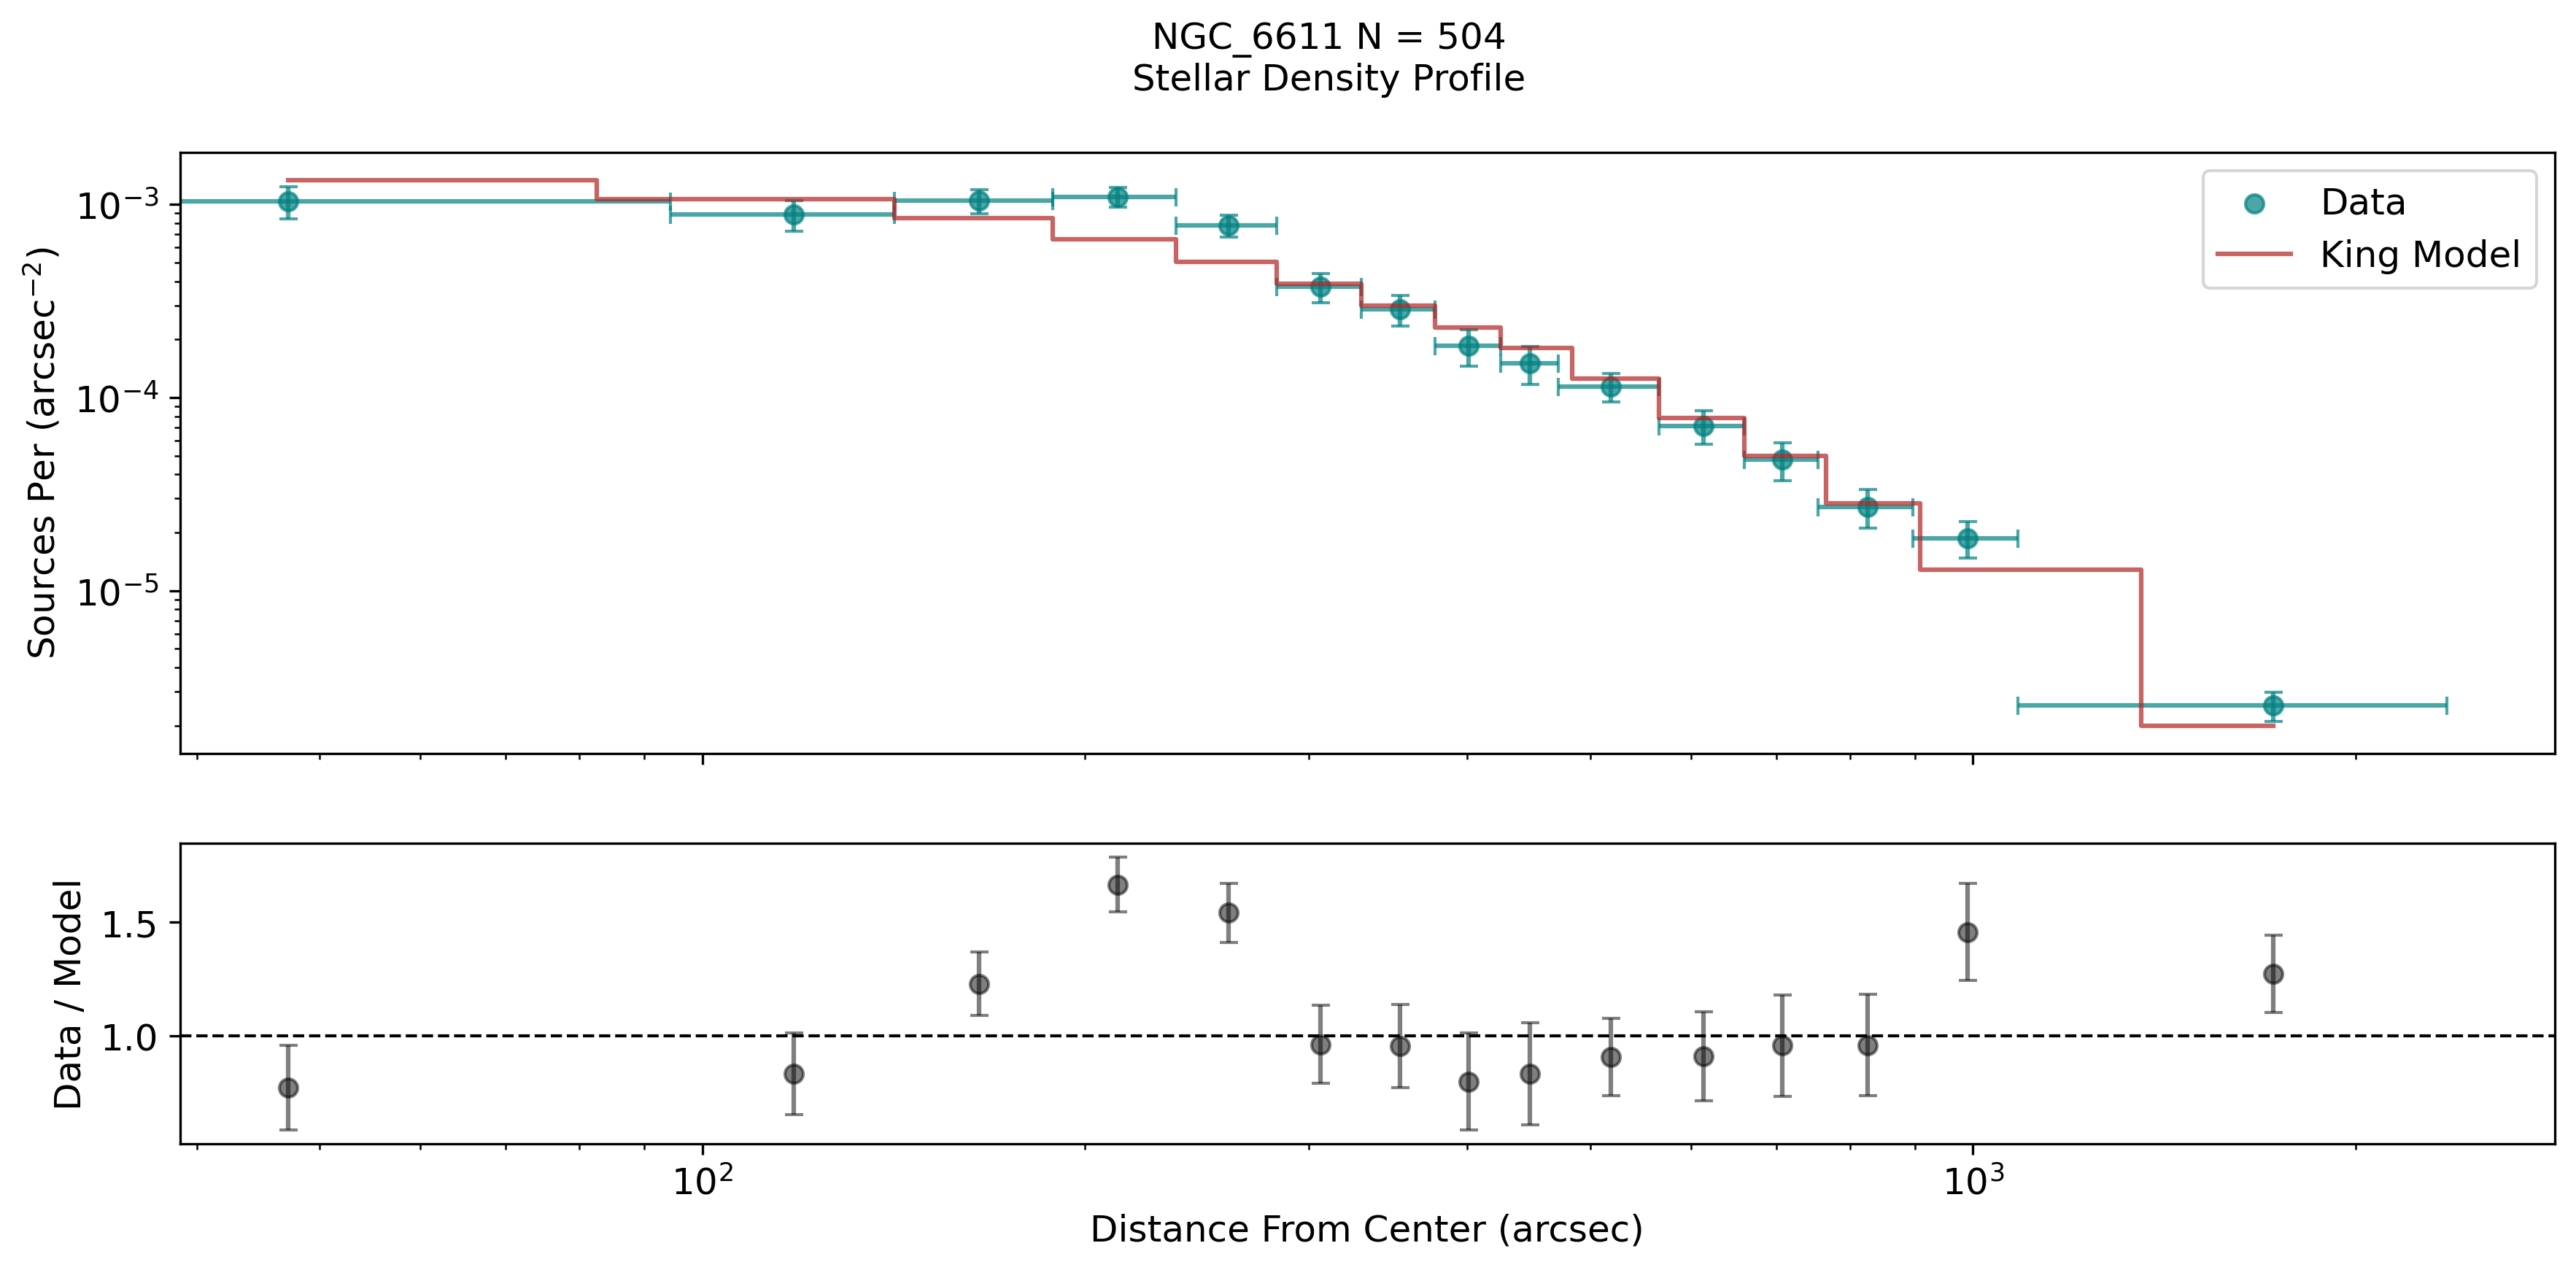

Parameter ranges for grid: [[0.0005342843483621602, 0.0033405955362604905], [0, 7.389771449767814e-06], [21.027601588811194, 432.7911533799848], [47.06502787933937, 2977.700581735173]]


MLE with 1 Sigma Erros
MLE rho_knot: 0.0019229202045708666 with 1 Sigma errors: [-0.00016522  0.00017136]
MLE c: 2.5687579491035855e-06 with 1 Sigma errors: [-4.27806707e-07  4.28378921e-07]
MLE r_c: 228.3298743373592 with 1 Sigma errors: [-20.28890503  22.64053614]
MLE r_t: 1513.1663349490173 with 1 Sigma errors: [-141.50120968  182.48641584]


MLE with 3 Sigma Erros
MLE rho_knot: 0.0019229202045708666 with 3 Sigma errors: [-0.00047931  0.00053243]
MLE c: 2.5687579491035855e-06 with 3 Sigma errors: [-2.02606595e-06  1.28716900e-06]
MLE r_c: 228.3298743373592 with 3 Sigma errors: [-55.66145348  78.24724638]
MLE r_t: 1513.1663349490173 with 3 Sigma errors: [-359.86217653  941.36691636]


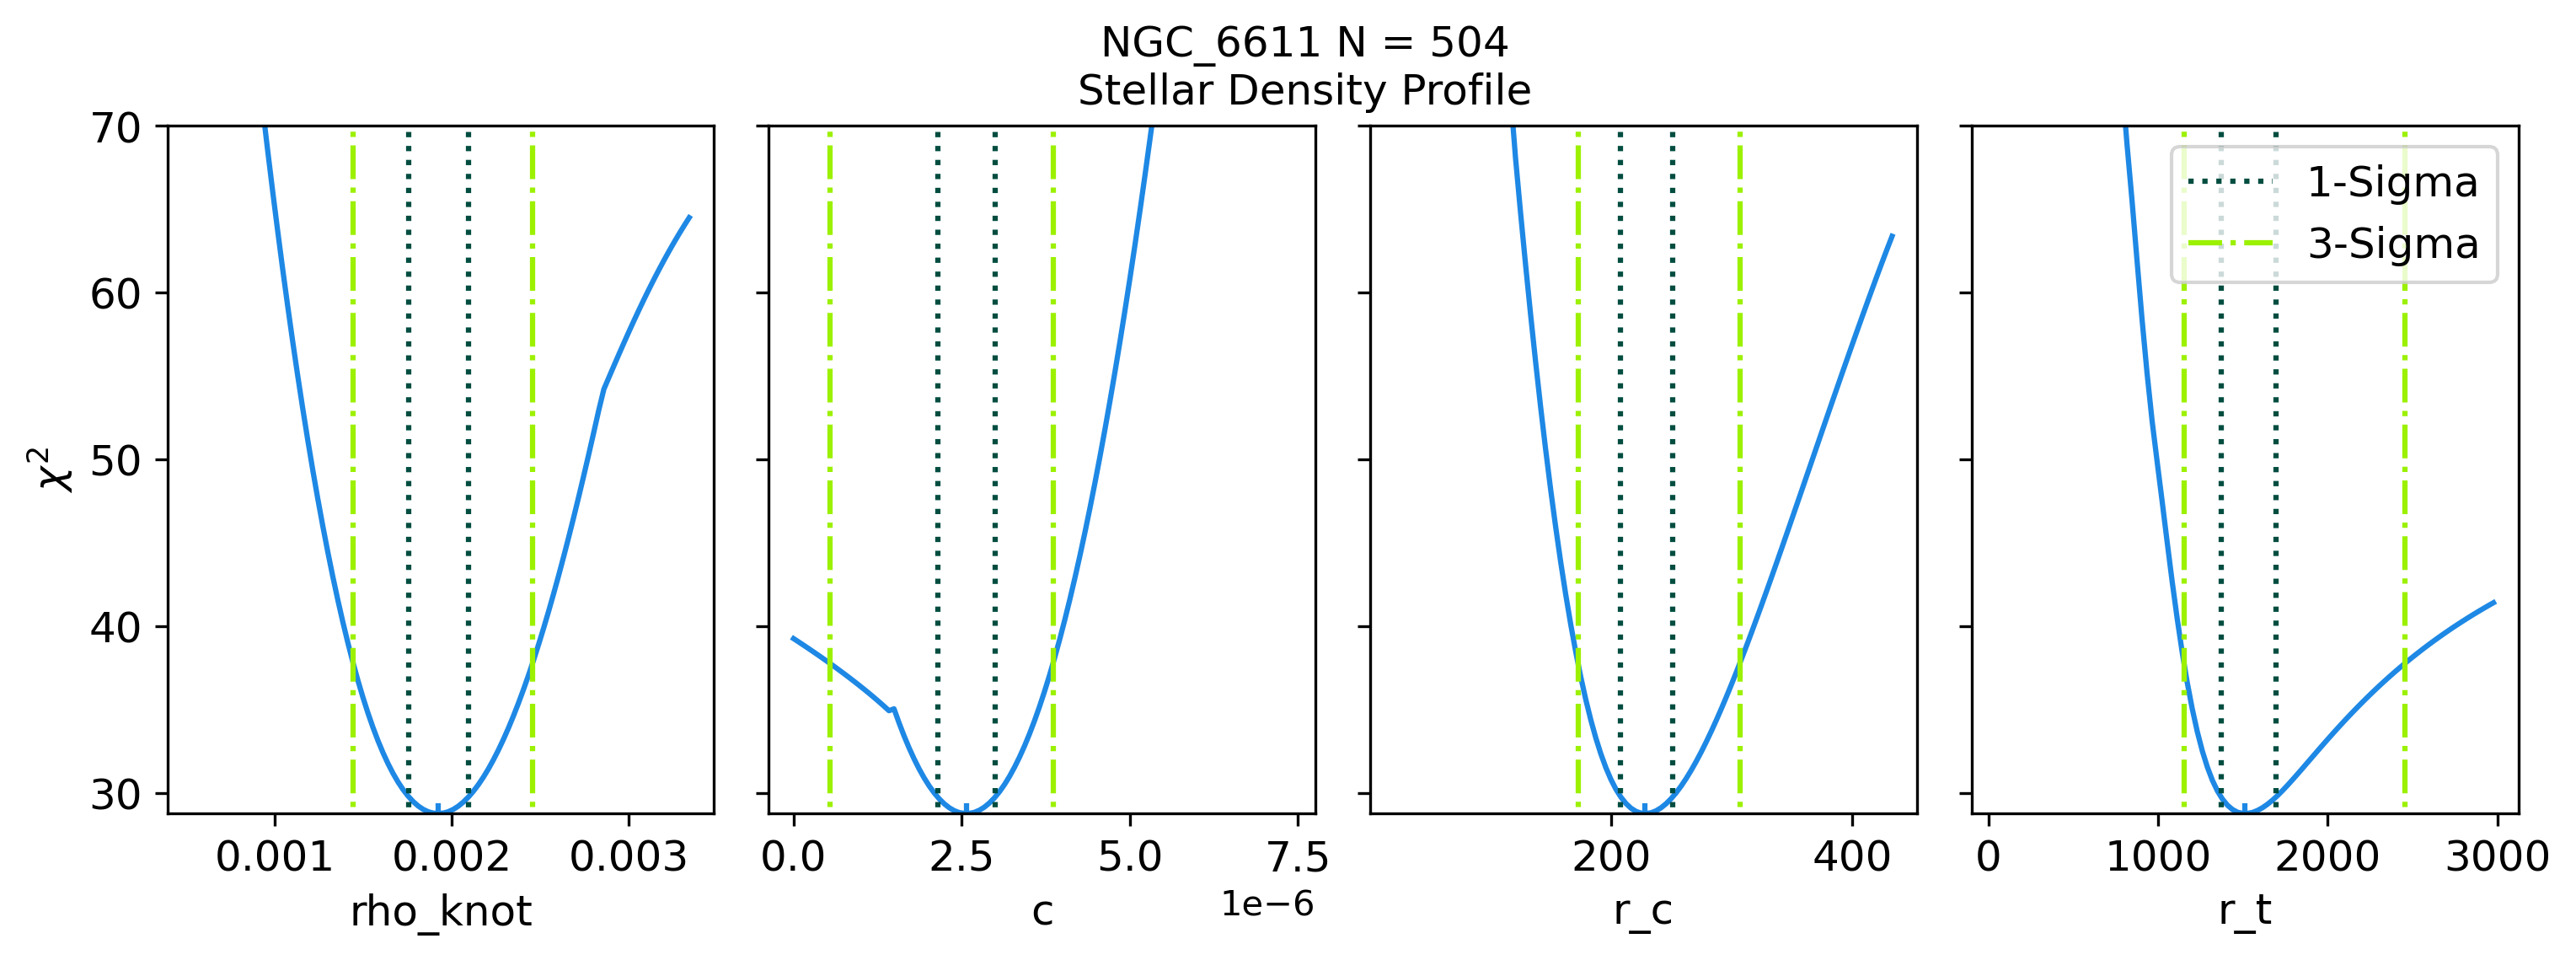

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 24
    # variables        = 4
    chi-square         = 28.5291535
    reduced chi-square = 1.42645768
    Akaike info crit   = 12.1489439
    Bayesian info crit = 16.8611593
[[Variables]]
    rho_knot:  7.4987e-04 +/- 1.8433e-04 (24.58%) (init = 1)
    c:         3.0200e-07 +/- 2.2466e-06 (743.92%) (init = 1e-05)
    r_c:       806.679603 +/- 164.894494 (20.44%) (init = 500)
    r_t:       2343.82529 +/- 424.324442 (18.10%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_knot, r_t) = -0.9799
    C(c, r_t)        = -0.9593
    C(rho_knot, c)   = +0.9262
    C(r_c, r_t)      = -0.8898
    C(rho_knot, r_c) = +0.8627
    C(c, r_c)        = +0.7895
Minimum Chi-squared = 28.52915350174733 for 20 d.o.f.
The goodness of fit is:  0.09745299459144757


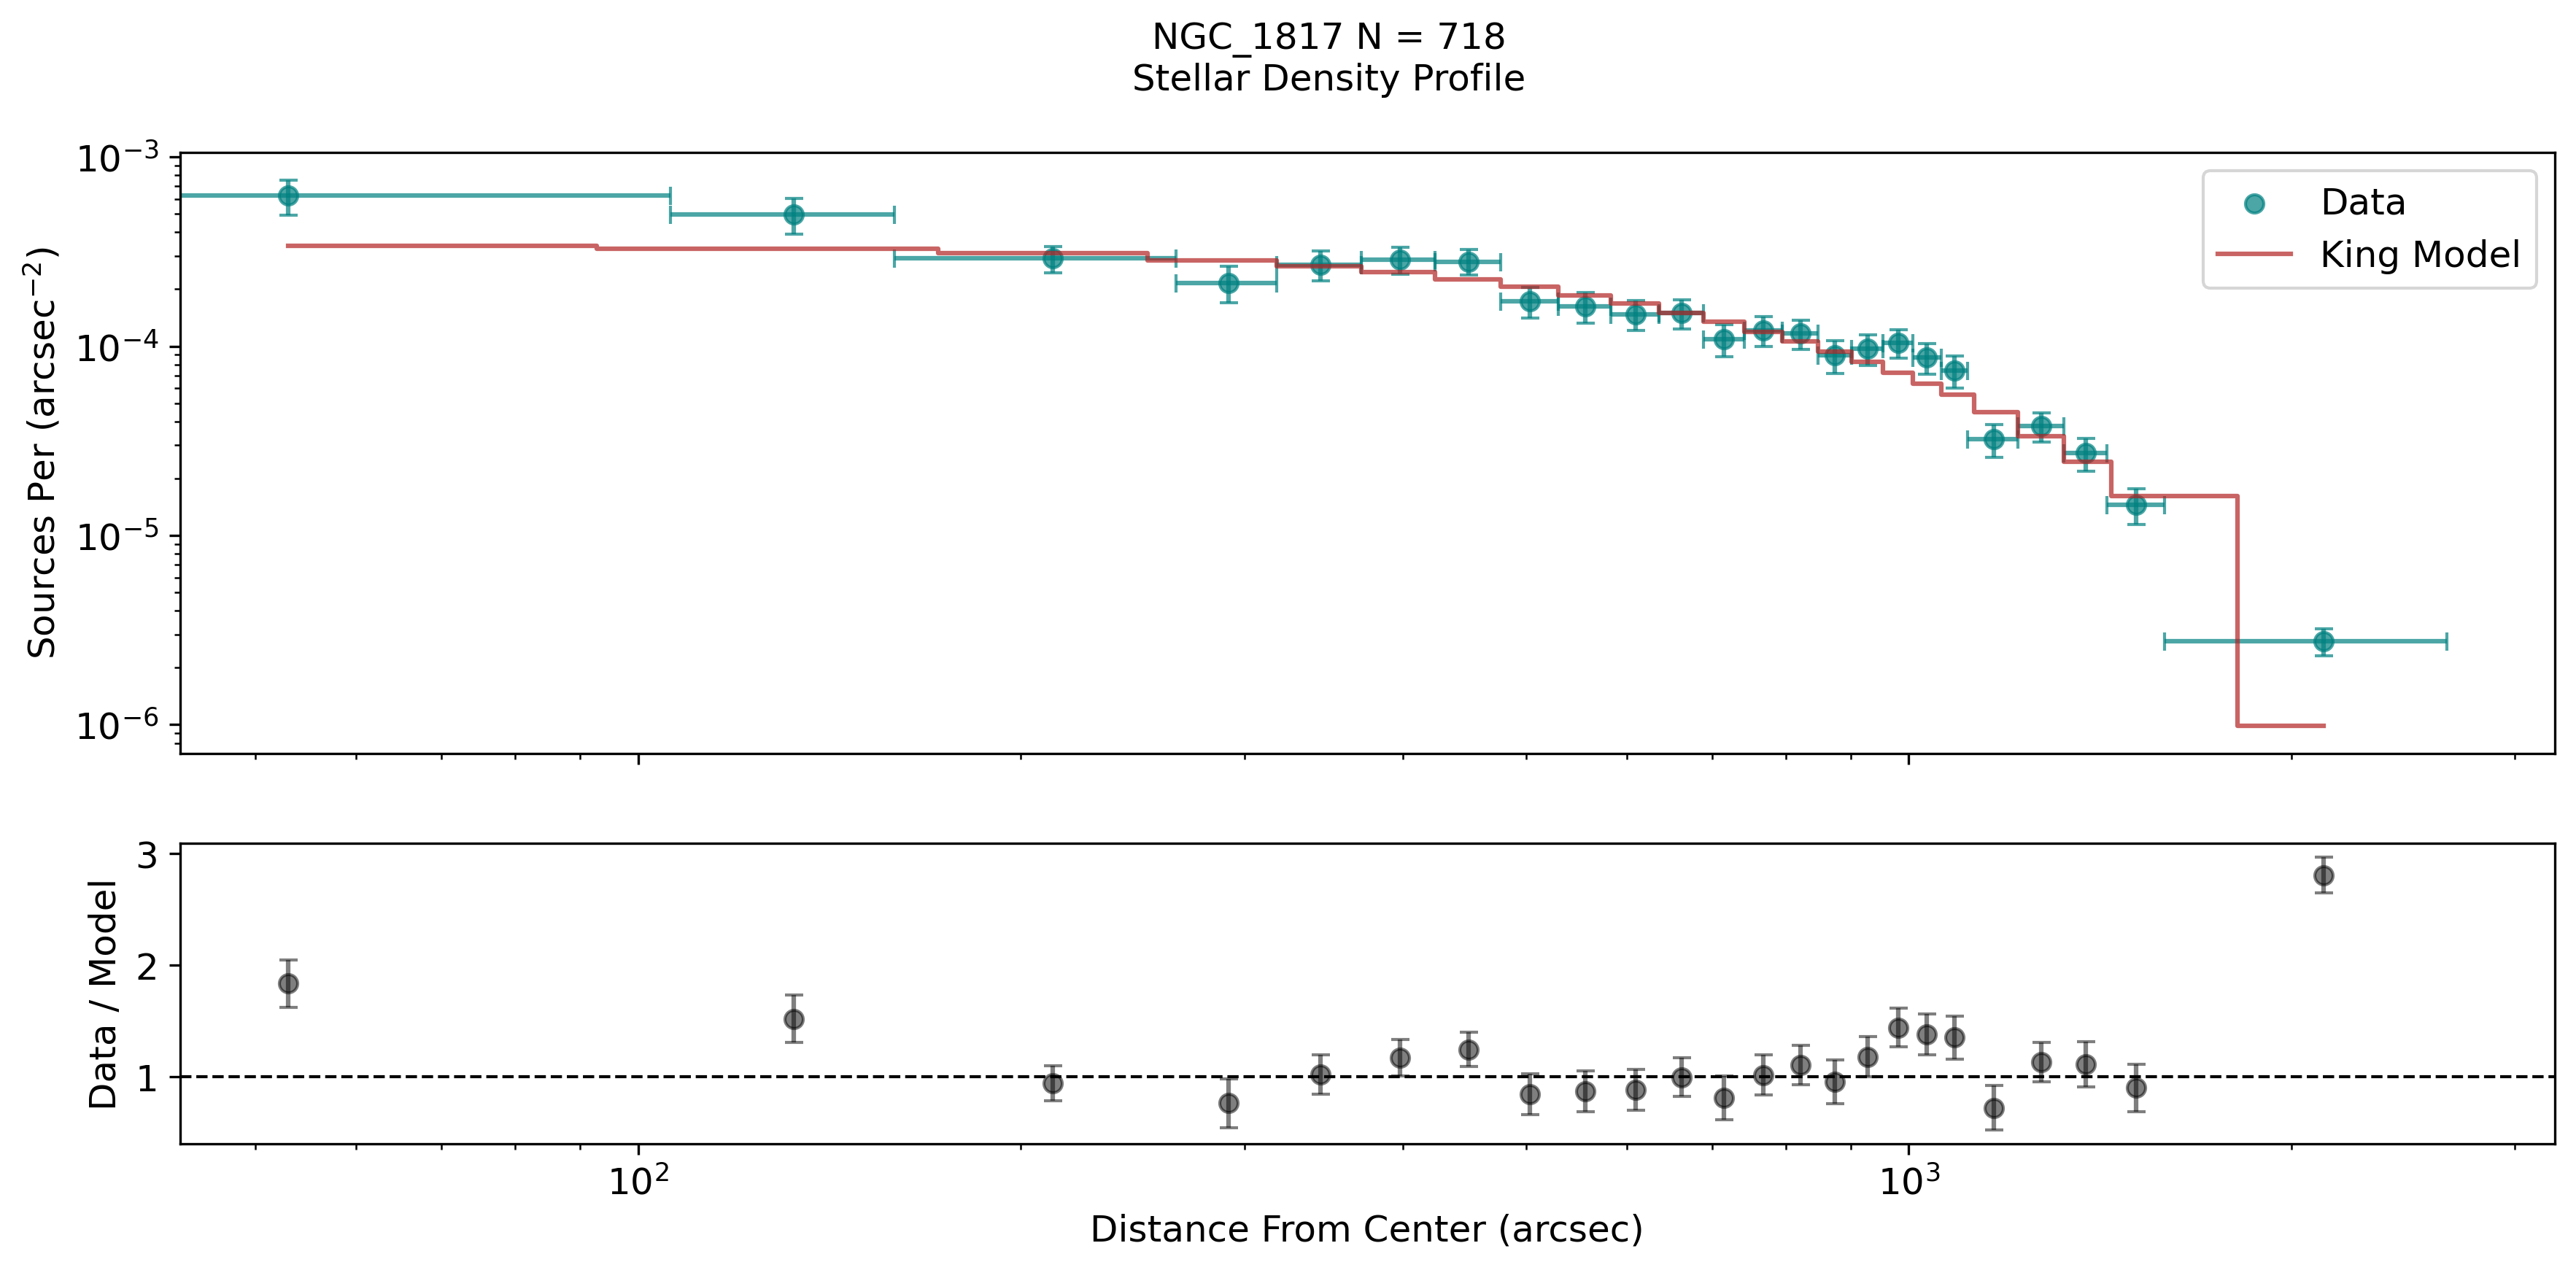

Parameter ranges for grid: [[0, 0.0016715170309285956], [0, 1.1535235930711229e-05], [0, 1631.1520728719156], [222.20308048377592, 4465.447499475456]]


MLE with 1 Sigma Erros
MLE rho_knot: 0.0007966413642798975 with 1 Sigma errors: [-0.00010441  0.00021448]
MLE c: 2.5849010577660773e-06 with 1 Sigma errors: [-2.46629458e-06  5.88474183e-07]
MLE r_c: 830.7810278703668 with 1 Sigma errors: [-149.24225597  177.11368619]
MLE r_t: 2220.9814485680017 with 1 Sigma errors: [-210.53648692  492.99762266]


MLE with 3 Sigma Erros
MLE rho_knot: 0.0007966413642798975 with 3 Sigma errors: [-0.00010464  0.00085826]
MLE c: 2.5849010577660773e-06 with 3 Sigma errors: [           nan 1.49214106e-06]
MLE r_c: 830.7810278703668 with 3 Sigma errors: [-398.4588288   790.68133156]
MLE r_t: 2220.9814485680017 with 3 Sigma errors: [-466.91759088           nan]


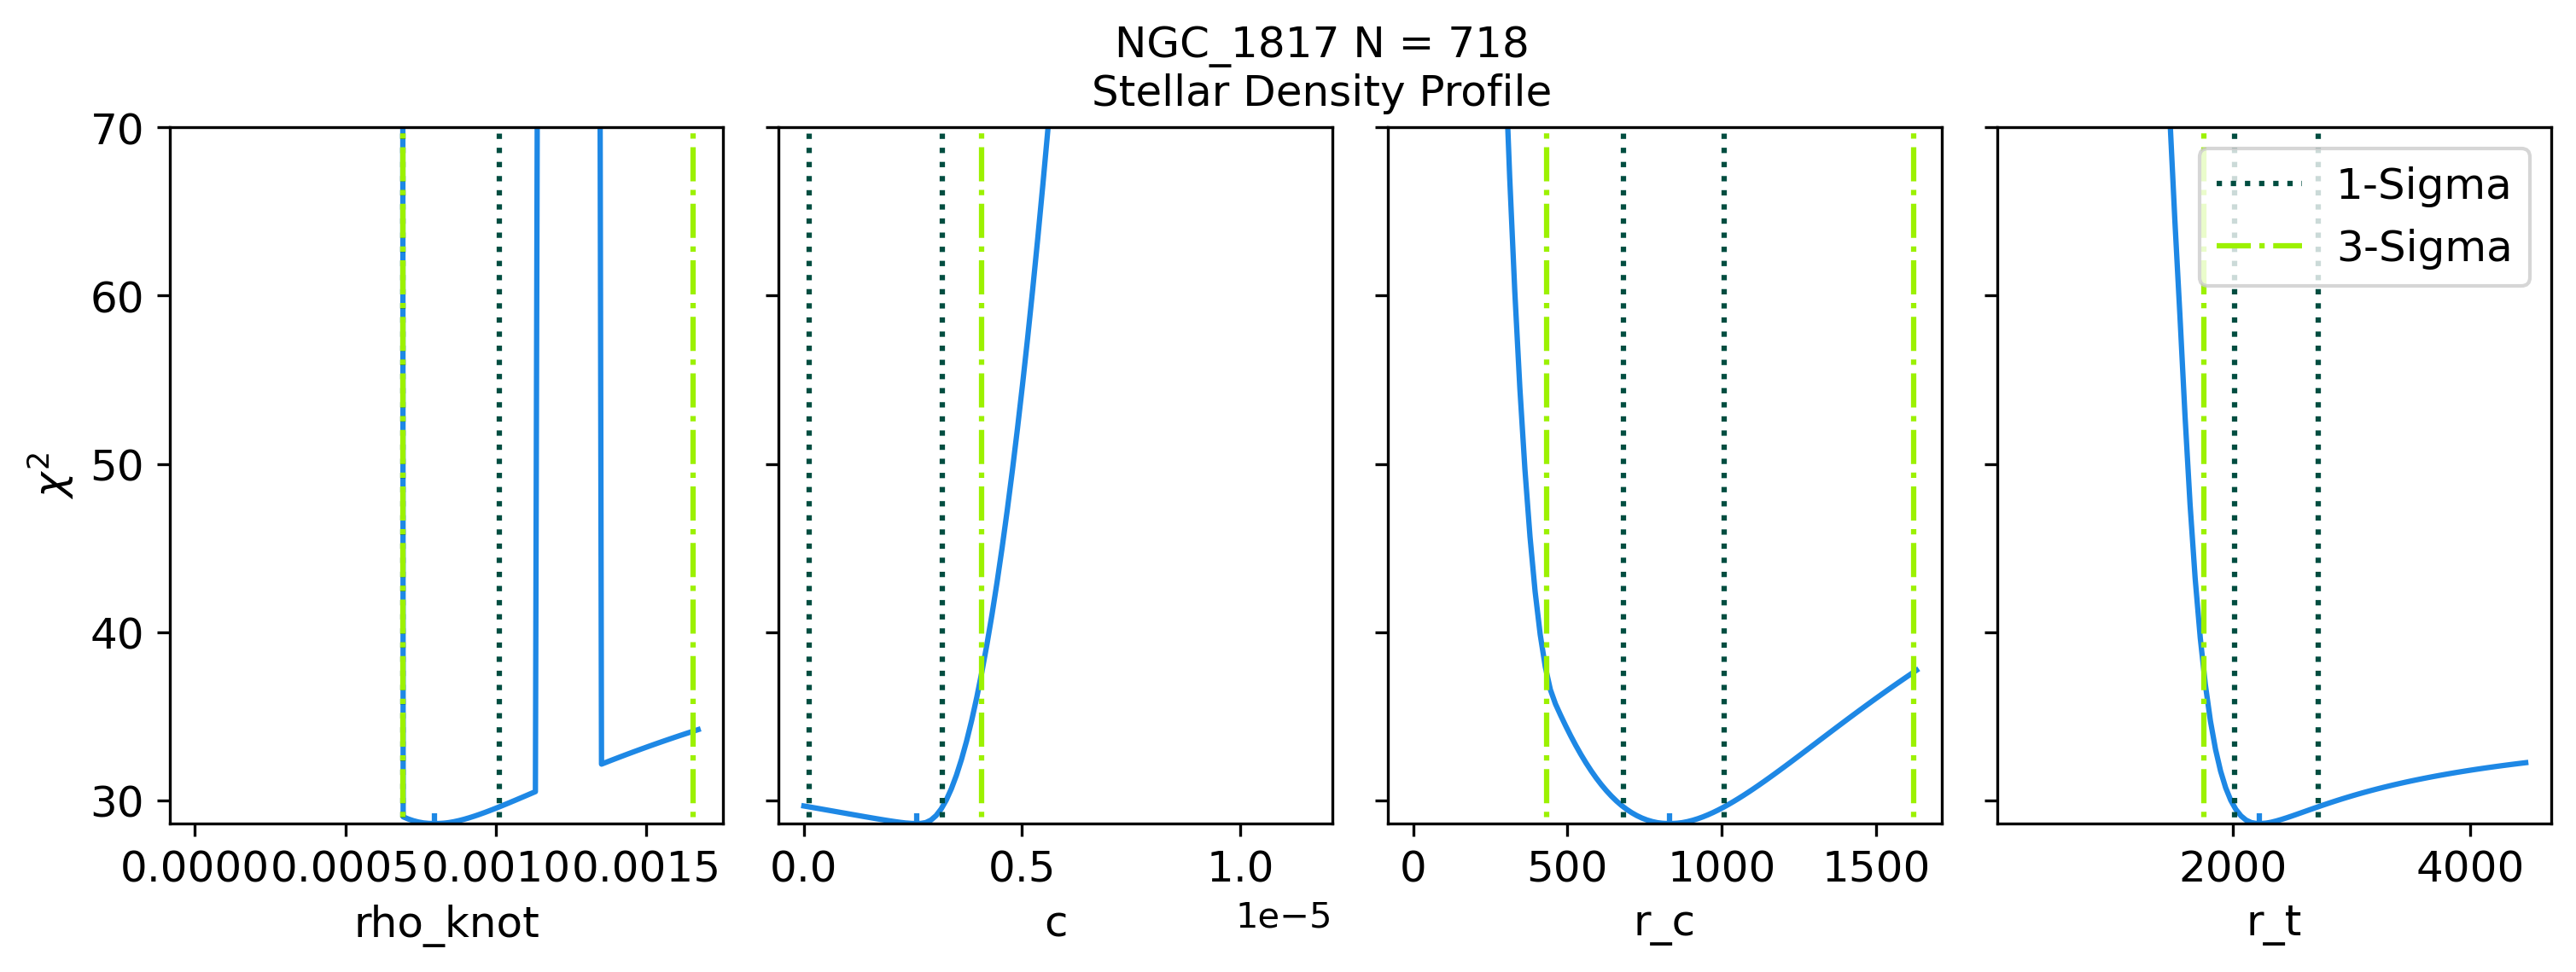

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 23
    # variables        = 4
    chi-square         = 44.6380631
    reduced chi-square = 2.34937174
    Akaike info crit   = 23.2511324
    Bayesian info crit = 27.7931093
[[Variables]]
    rho_knot:  0.00122741 +/- 1.5147e-04 (12.34%) (init = 1)
    c:         1.9729e-07 +/- 4.0063e-07 (203.07%) (init = 1e-05)
    r_c:       308.817005 +/- 34.7376436 (11.25%) (init = 500)
    r_t:       4825.34090 +/- 826.537790 (17.13%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, r_t)        = -0.9050
    C(rho_knot, r_c) = -0.7793
    C(r_c, r_t)      = -0.6669
    C(c, r_c)        = +0.5407
    C(rho_knot, r_t) = +0.1597
    C(rho_knot, c)   = -0.1019
Minimum Chi-squared = 44.63806313558491 for 19 d.o.f.
The goodness of fit is:  0.0007700326000644705


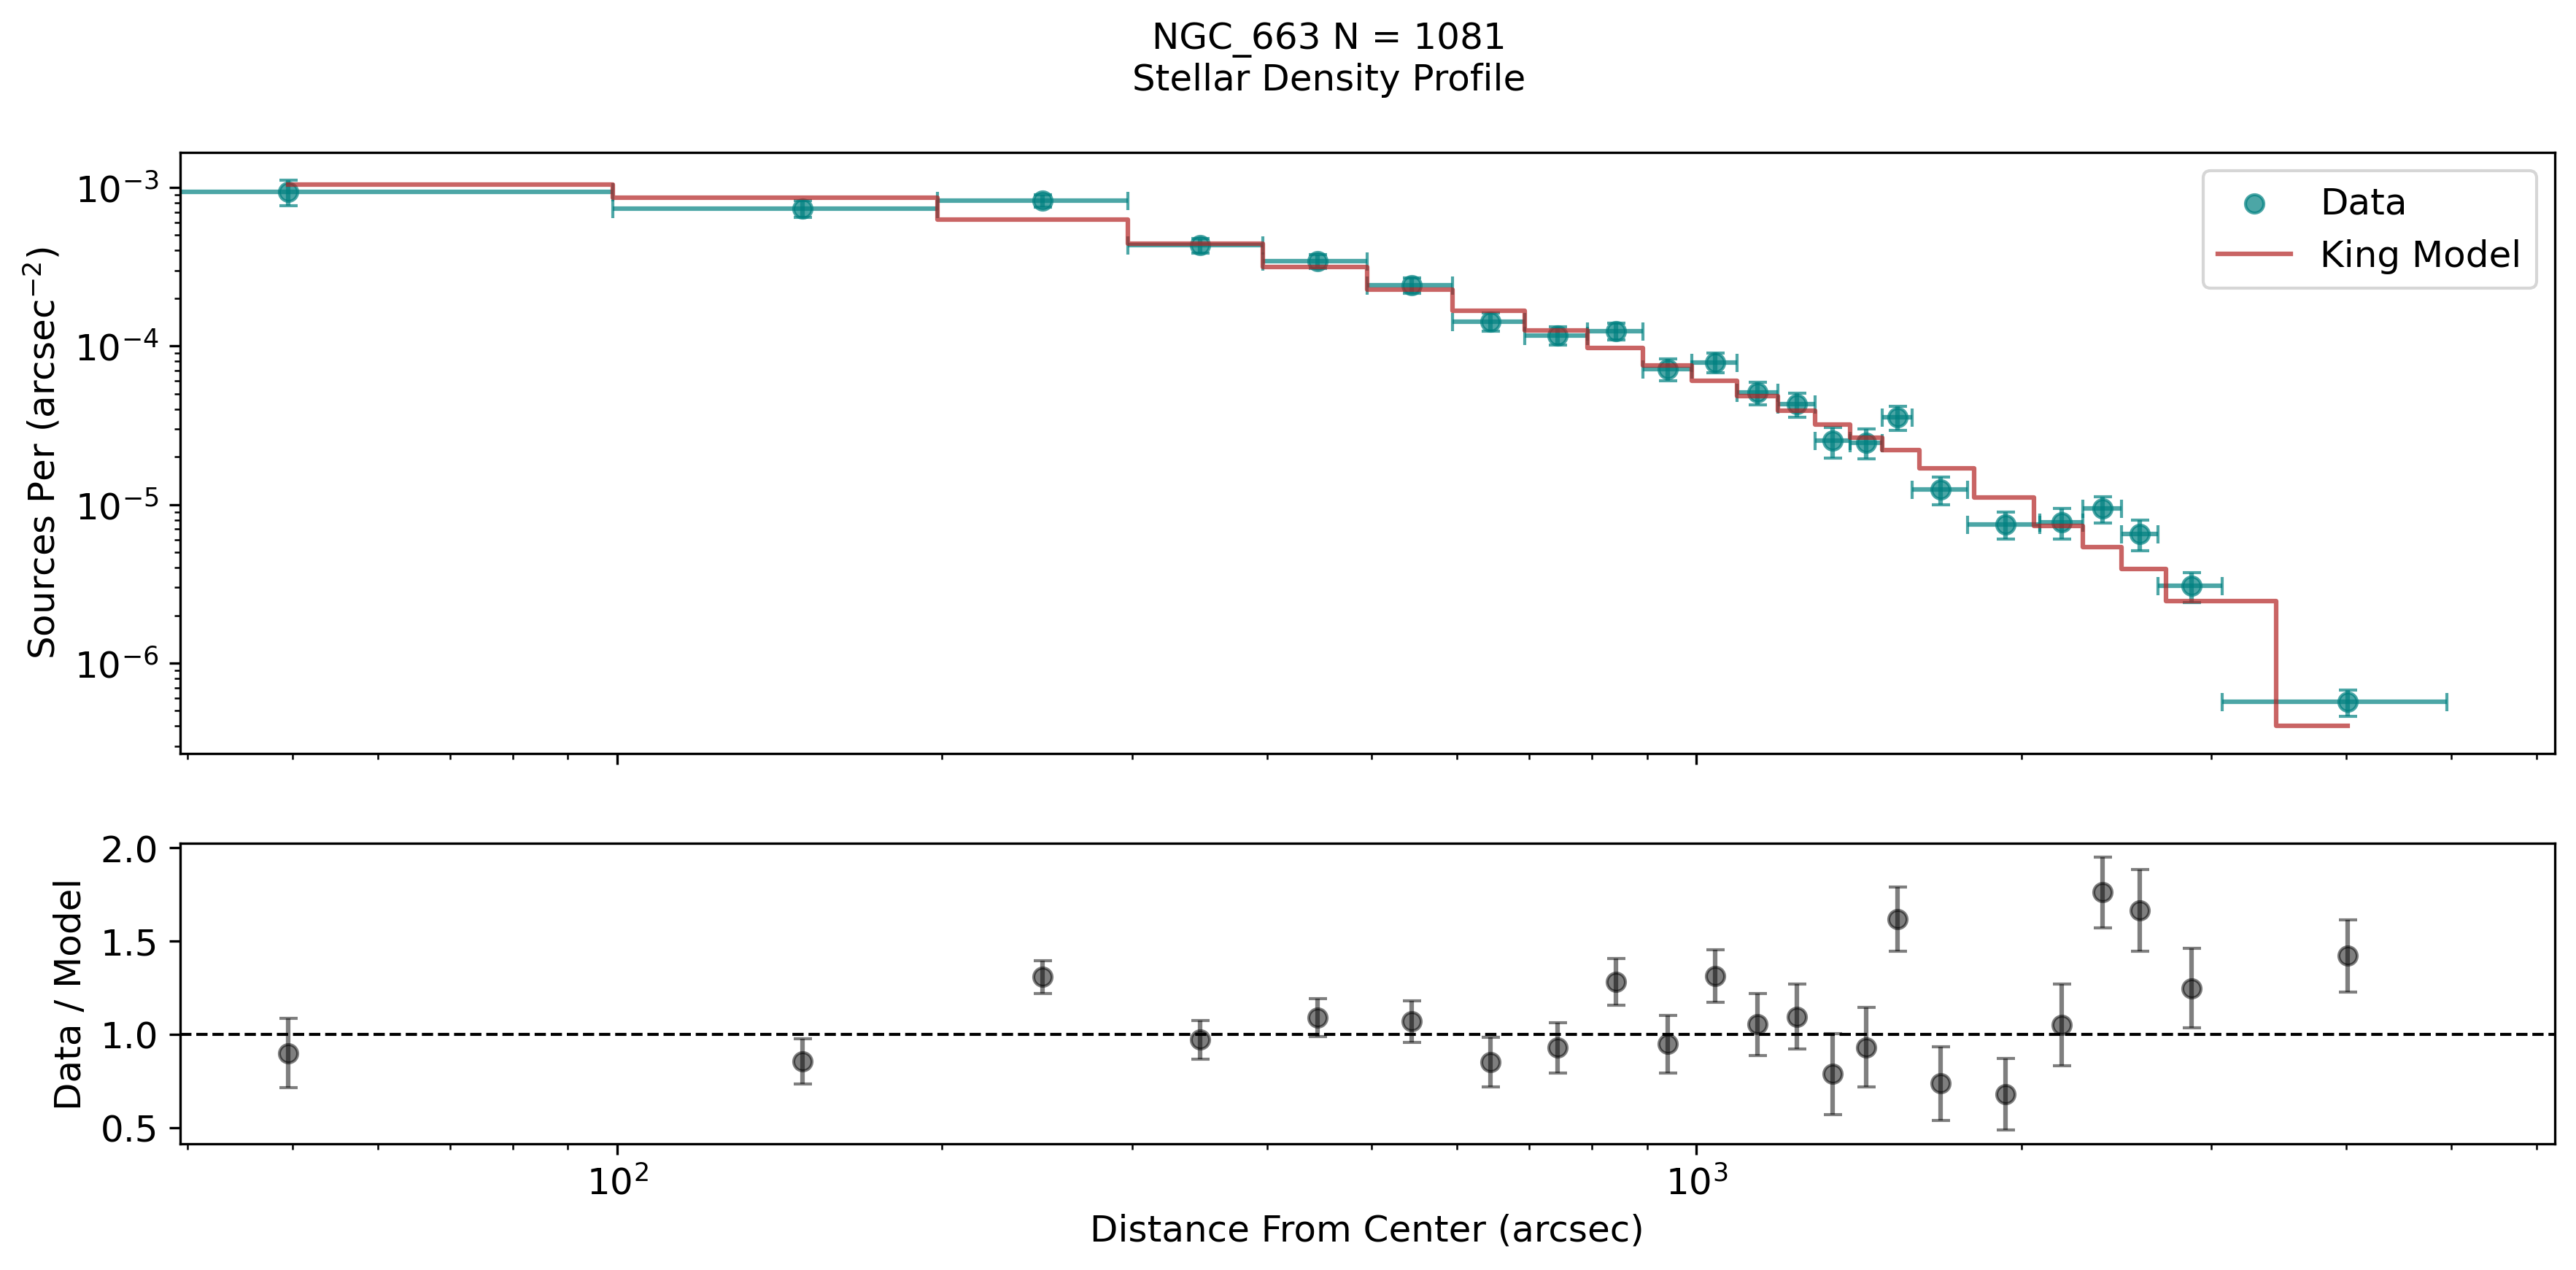

Parameter ranges for grid: [[0.00047005735419258354, 0.0019847610558619876], [0, 2.2004260877511526e-06], [135.12878687119147, 482.50522319165043], [692.6519505058386, 8958.029851323736]]


MLE with 1 Sigma Erros
MLE rho_knot: 0.0012255083873105813 with 1 Sigma errors: [-9.12846488e-05  9.64893957e-05]
MLE c: 4.361736819016174e-07 with 1 Sigma errors: [-2.61787773e-07  1.84474108e-07]
MLE r_c: 312.1931234455538 with 1 Sigma errors: [-20.37563682  21.83071309]
MLE r_t: 4691.068587263288 with 1 Sigma errors: [-401.28714293  560.39566401]


MLE with 3 Sigma Erros
MLE rho_knot: 0.0012255083873105813 with 3 Sigma errors: [-0.00026024  0.0003066 ]
MLE c: 4.361736819016174e-07 with 3 Sigma errors: [          nan 4.5507343e-07]
MLE r_c: 312.1931234455538 with 3 Sigma errors: [-57.76577398  70.77389965]
MLE r_t: 4691.068587263288 with 3 Sigma errors: [-962.43074462 2772.52756772]


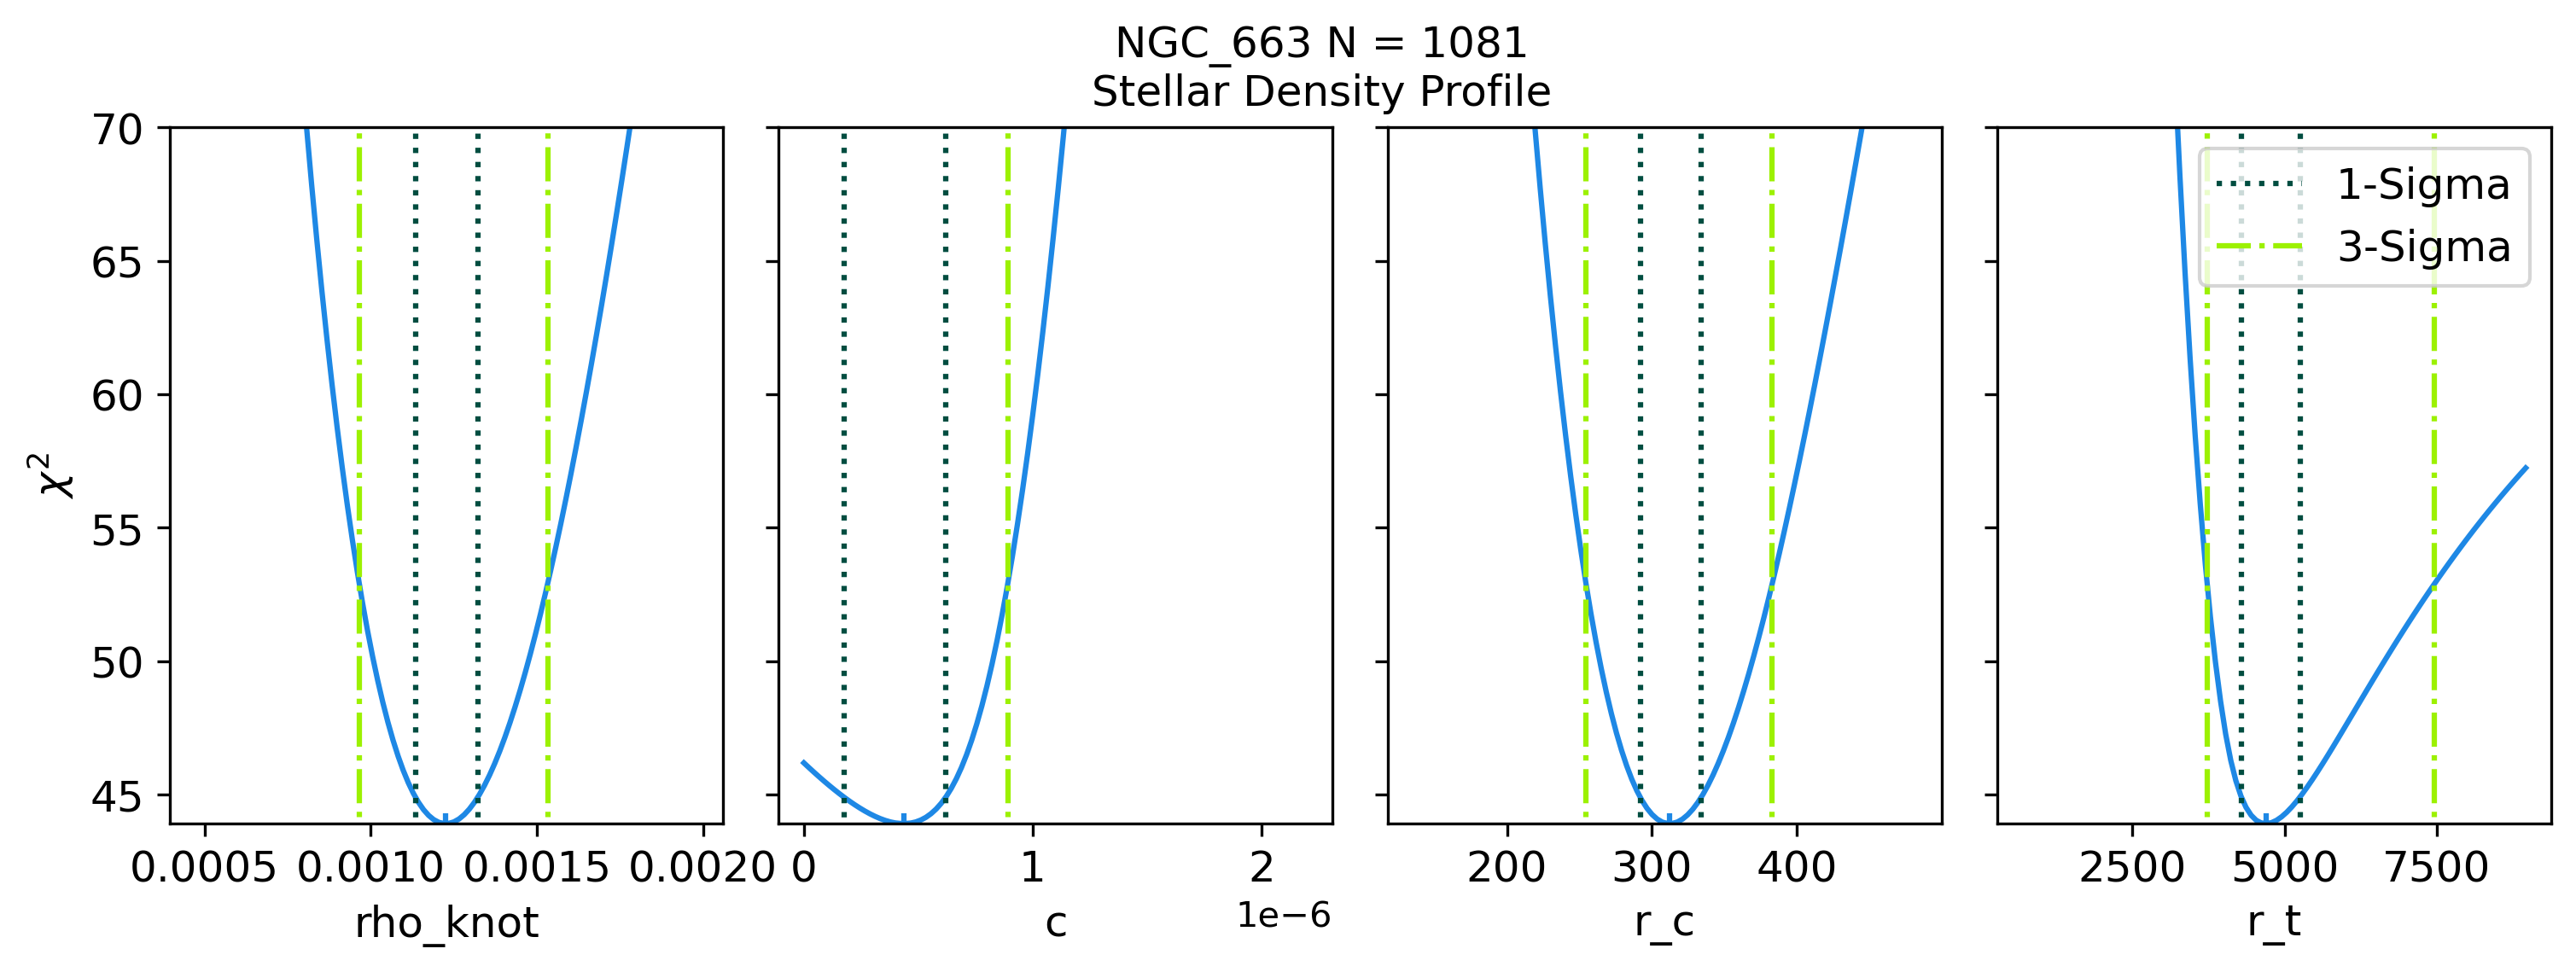

In [13]:
# aprox 2 min for three clusters, most of this is in the confidence intervals function 
for cluster_name in assigned_clusters:
    result, xdata,ydata,yerrs  = fit_and_plot_king(stars_df, cluster_name, print_output=True, plot=True)
    get_confidence_intervals(result, stars_df, cluster_name, plotting=True, print_output=True)

# Task 3
An interesting question is whether or not the stars in a cluster follow the same stellar density profiles
when they are selected according to different properties. In particular, we would like to see if the
populations are well mixed according to their G band magnitude and their absolute proper motion
(combining RA and DE proper motion directions). If they are well-mixed, subsamples selected on the
given quantity will show similar density profiles. For each of these two quantities, split the stars from
each cluster into two subsamples corresponding to different percentile ranges (your choice) of the
given observable quantity. Then for each cluster, fit the resulting two density profiles together and
determine whether the stellar density profile model parameters depend on the chosen quantity. 

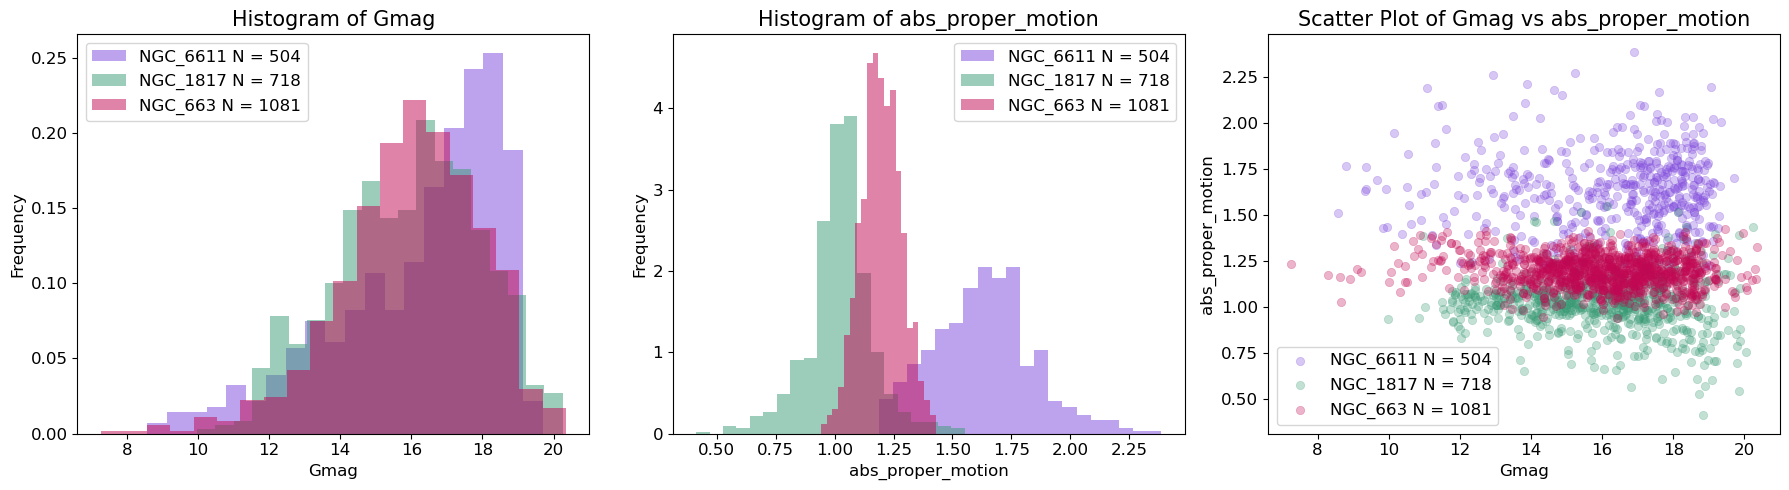

In [ ]:
import matplotlib.pyplot as plt

# Create subplots with two side-by-side histograms and one scatter plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), dpi=300)

# custom colors
colors = ['#7D46DC', '#3A9B76', '#C20853']

# Iterate over each star name and plot histograms
for i, cluster_name in enumerate(assigned_clusters):
    cluster_data = stars_df[stars_df['Name'] == cluster_name]

    label = cluster_name + ' N = ' + str(len(cluster_data['Gmag']))

    # Histogram for 'Gmag'
    axs[0].hist(cluster_data['Gmag'], bins=20, alpha=0.5, color=colors[i], label=label, density=True)

    # Histogram for 'abs_proper_motion'
    axs[1].hist(cluster_data['abs_proper_motion'], bins=20, alpha=0.5, color=colors[i], label=label, density=True)

    # Scatter plot for 'Gmag' vs 'abs_proper_motion'
    axs[2].scatter(cluster_data['Gmag'], cluster_data['abs_proper_motion'], color=colors[i], label=label, alpha=0.3, linewidth=0.5)
    axs[i].tick_params(axis='both', which='both', labelsize=12)

# Set labels and titles for histograms
axs[0].set_xlabel('Gmag', size=12)
axs[0].set_ylabel('Frequency', size=12)
axs[0].set_title('Histogram of Gmag', size=15)

axs[1].set_xlabel('abs_proper_motion', size=12)
axs[1].set_ylabel('Frequency', size=12)
axs[1].set_title('Histogram of abs_proper_motion', size=15)

# Set labels and title for scatter plot
axs[2].set_xlabel('Gmag', size=12)
axs[2].set_ylabel('abs_proper_motion', size=12)
axs[2].set_title('Scatter Plot of Gmag vs abs_proper_motion', size=15)

# Add legend to all subplots
axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)
axs[2].legend(fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig(cluster_name +'_correlation', bbox_inches='tight')
plt.show()


In [ ]:
# purple star cluster follows a different distrubution 
# others are guassians, but purple has a big negative skew

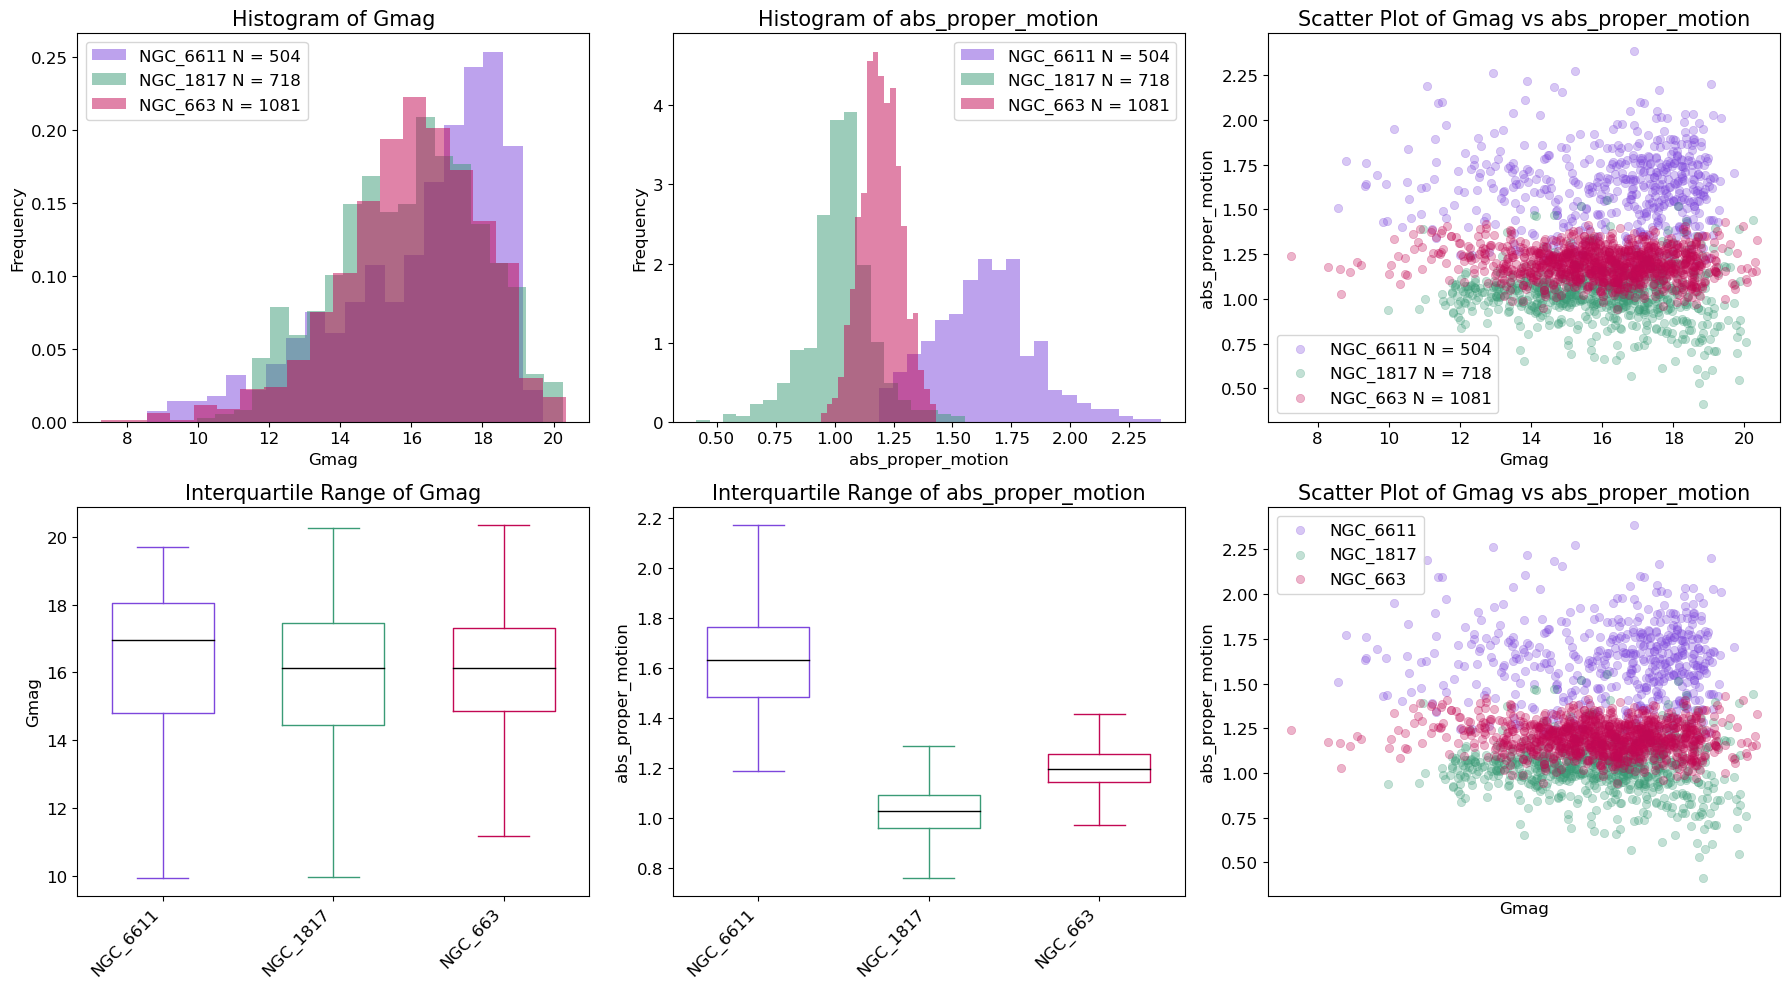

In [ ]:
import matplotlib.pyplot as plt

# Create subplots with two side-by-side histograms and one scatter plot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), dpi=300)

# custom colors
colors = ['#7D46DC', '#3A9B76', '#C20853']

# Iterate over each star name and plot histograms
for i, cluster_name in enumerate(assigned_clusters):
    cluster_data = stars_df[stars_df['Name'] == cluster_name]

    label = cluster_name + ' N = ' + str(len(cluster_data['Gmag']))

    # Histogram for 'Gmag'
    axs[0, 0].hist(cluster_data['Gmag'], bins=20, alpha=0.5, color=colors[i], label=label, density=True)

    # Histogram for 'abs_proper_motion'
    axs[0, 1].hist(cluster_data['abs_proper_motion'], bins=20, alpha=0.5, color=colors[i], label=label, density=True)

    # Scatter plot for 'Gmag' vs 'abs_proper_motion'
    axs[0, 2].scatter(cluster_data['Gmag'], cluster_data['abs_proper_motion'], color=colors[i], label=label, alpha=0.3, linewidth=0.5)
    axs[0, i].tick_params(axis='both', which='both', labelsize=12)
    #axs[i, i].tick_params(axis='both', which='both', labelsize=12)
    axs[0, i].tick_params(axis='both', which='both', labelsize=12)
    axs[1, i].tick_params(axis='both', which='both', labelsize=12)
   # axs[2, i].tick_params(axis='both', which='both', labelsize=12)

# Set labels and titles for histograms
axs[0, 0].set_xlabel('Gmag', size=12)
axs[0, 0].set_ylabel('Frequency', size=12)
axs[0, 0].set_title('Histogram of Gmag', size=15)

axs[0, 1].set_xlabel('abs_proper_motion', size=12)
axs[0, 1].set_ylabel('Frequency', size=12)
axs[0, 1].set_title('Histogram of abs_proper_motion', size=15)

# Set labels and title for scatter plot
axs[0, 2].set_xlabel('Gmag', size=12)
axs[0, 2].set_ylabel('abs_proper_motion', size=12)
axs[0, 2].set_title('Scatter Plot of Gmag vs abs_proper_motion', size=15)

# Add legend to all subplots
axs[0, 0].legend(fontsize=12)
axs[0, 1].legend(fontsize=12)
axs[0, 2].legend(fontsize=12)

# Iterate over each star name and plot interquartile range diagrams
for i, cluster_name in enumerate(assigned_clusters):
    cluster_data = stars_df[stars_df['Name'] == cluster_name]

    # Interquartile range diagram for 'Gmag'
    axs[1, 0].boxplot(cluster_data['Gmag'], positions=[i], widths=0.6, showfliers=False, boxprops=dict(color=colors[i]),
                   medianprops=dict(color='black'), whiskerprops=dict(color=colors[i]), capprops=dict(color=colors[i]))

    # Interquartile range diagram for 'abs_proper_motion'
    axs[1, 1].boxplot(cluster_data['abs_proper_motion'], positions=[i], widths=0.6, showfliers=False,
                   boxprops=dict(color=colors[i]), medianprops=dict(color='black'),
                   whiskerprops=dict(color=colors[i]), capprops=dict(color=colors[i]))

    # Scatter plot for 'Gmag' vs 'abs_proper_motion'
    axs[1, 2].scatter(cluster_data['Gmag'], cluster_data['abs_proper_motion'], color=colors[i], label=cluster_name, alpha=0.3, linewidth=0.5)
    

# Set labels and titles for interquartile range diagrams
#axs[1, 0].set_xlabel('Cluster', size=12)
axs[1, 0].set_ylabel('Gmag', size=12)
axs[1, 0].set_title('Interquartile Range of Gmag', size=15)

#axs[1, 1].set_xlabel('Cluster', size=12)
axs[1, 1].set_ylabel('abs_proper_motion', size=12)
axs[1, 1].set_title('Interquartile Range of abs_proper_motion', size=15)

# Set labels and title for scatter plot
axs[1, 2].set_xlabel('Gmag', size=12)
axs[1, 2].set_ylabel('abs_proper_motion', size=12)
axs[1, 2].set_title('Scatter Plot of Gmag vs abs_proper_motion', size=15)

# Set x-axis ticks to cluster names
axs[1, 0].set_xticks(range(len(assigned_clusters)))
axs[1, 0].set_xticklabels(assigned_clusters, rotation=45, ha='right')

axs[1, 1].set_xticks(range(len(assigned_clusters)))
axs[1, 1].set_xticklabels(assigned_clusters, rotation=45, ha='right')

axs[1, 2].set_xticks([])  # No x-axis ticks for the scatter plot

# Add legend to the scatter plot
axs[1, 2].legend(fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('merged_plots', bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd

# Example: Splitting data based on percentiles of 'Gmag' for each cluster
percentile_low = 25
percentile_high = 75

# Function to compute percentiles within each cluster
def compute_percentiles(group):
    group['Gmag_percentile_range'] = pd.cut(group['Gmag'],
                                             bins=[-float('inf'), group['Gmag'].quantile(percentile_low/100), float('inf')],
                                             labels=['Gmag_low_percentile', 'Gmag_high_percentile'])
    
    group['abs_proper_motion_percentile_range'] = pd.cut(group['abs_proper_motion'],
                                                         bins=[-float('inf'), group['abs_proper_motion'].quantile(percentile_low/100), float('inf')],
                                                         labels=['abs_proper_motion_low_percentile', 'abs_proper_motion_high_percentile'])
    return group

# Apply the function within each cluster
stars_df = stars_df.groupby('Name').apply(compute_percentiles)

# Optional: Remove the temporary columns if needed
# stars_df = stars_df.drop(columns=['Gmag_percentile_range', 'abs_proper_motion_percentile_range'])

# Split the data into two DataFrames based on the percentile_range columns
low_percentile_data = stars_df[stars_df['Gmag_percentile_range'] == 'Gmag_low_percentile']
high_percentile_data = stars_df[stars_df['Gmag_percentile_range'] == 'Gmag_high_percentile']


In [ ]:
stars_df

Name    ID              GaiaDR3  inrt      Prob  \
Name                                                                        
1636-283   0          1636-283     0  6032349260227596544     0  0.747692   
           1          1636-283     0  6032358331198284160     1  1.000000   
           2          1636-283     0  6032358331198285696     1  0.843798   
           3          1636-283     0  6032358331198286080     1  1.000000   
           4          1636-283     0  6032358670488486784     1  1.000000   
...                        ...   ...                  ...   ...       ...   
vdBergh_92 1291924  vdBergh_92  7163  3045840104515988992     1  1.000000   
           1291925  vdBergh_92  7163  3045840074455065088     1  0.838193   
           1291926  vdBergh_92  7163  3045840074453671680     1  0.639341   
           1291927  vdBergh_92  7163  3045840654267074048     1  0.738133   
           1291928  vdBergh_92  7163  3046211537585833984     1  0.811015   

                         RAdeg   e_RAdeg      DEdeg   e_DEdeg        GLON  \
Name                                                                        
1636-283   0        249.708525  0.201080 -28.585117  0.115789  351.679705   
           1        249.866424  0.020684 -28.402037  0.013691  351.914287   
           2        249.865221  0.046356 -28.399406  0.029595  351.915643   
           3        249.861159  0.045101 -28.400698  0.030237  351.912273   
           4        249.939480  0.038724 -28.429366  0.023344  351.935370   
...                        ...       ...        ...       ...         ...   
vdBergh_92 1291924  106.116546  0.110176 -11.474387  0.111851  224.621323   
           1291925  106.136236  0.049847 -11.471452  0.049169  224.627544   
           1291926  106.135606  0.056229 -11.468653  0.058581  224.624770   
           1291927  106.159649  0.058318 -11.436082  0.062037  224.606570   
           1291928  106.285883  0.010255 -11.502450  0.011068  224.722285   

                    ...        VarFlag  NSS  RVS  cluster_mean_RAdeg  \
Name                ...                                                
1636-283   0        ...  NOT_AVAILABLE    0    0          249.875092   
           1        ...  NOT_AVAILABLE    0    0          249.875092   
           2        ...  NOT_AVAILABLE    0    0          249.875092   
           3        ...  NOT_AVAILABLE    0    0          249.875092   
           4        ...  NOT_AVAILABLE    0    0          249.875092   
...                 ...            ...  ...  ...                 ...   
vdBergh_92 1291924  ...  NOT_AVAILABLE    0    0          106.092489   
           1291925  ...  NOT_AVAILABLE    0    0          106.092489   
           1291926  ...  VARIABLE         0    0          106.092489   
           1291927  ...  NOT_AVAILABLE    0    0          106.092489   
           1291928  ...  VARIABLE         0    1          106.092489   

                    cluster_mean_DEdeg  radial_separation_arcsec  \
Name                                                               
1636-283   0                -28.407748                875.950999   
           1                -28.407748                 37.369190   
           2                -28.407748                 46.525674   
           3                -28.407748                 56.214438   
           4                -28.407748                244.513293   
...                                ...                       ...   
vdBergh_92 1291924          -11.464422                 93.740769   
           1291925          -11.464422                159.510418   
           1291926          -11.464422                155.967010   
           1291927          -11.464422                262.419583   
           1291928          -11.464422                709.551647   

                    abs_proper_motion  percentile_range  \
Name                                                      
1636-283   0                 6.299915   High Percentile   
           1           